# Load results

In [1]:
results_Fp = load('results_Fp.sobj')   # Prime field results: {p: {a : {m : {o : attackInfo}}}}
results_F2n = load('results_F2n.sobj') # Binary field results: {n: {a : {m : {o : attackInfo}}}}
load('complexities.sage')  # complexity formulas

In [2]:
results_Fp.keys()

dict_keys([(18446744073709551263, 1), (4294967087, 1), (65537, 1), ('BLS12-381', 1), ('BN-254', 1)])

In [3]:
results_F2n.keys()

dict_keys([(2, 127), (2, 15), (2, 17), (2, 255), (2, 257), (2, 31), (2, 63), (2, 65)])

# Overview: Experimental results

In [4]:
# First integers, second names prime fields
sort_p_n = lambda r: (isinstance(r[0], str), r)

def attackInfoTable(results, targets=None, cols=None, w=2):
    tableData = [['p','n','a','m','o','$n_r$','$n_v$','$n_e$','mdeg',
                  '$T_{GB}$','dreg','$\\mathcal{C}_{GB}$','$T_{FGLM}$',
                  'vsdim','$\\mathcal{C}_{FGLM}$','$T_{FAC}$','unideg',
                  '$\\mathcal{C}_{FAC}$','nsols','nsols_mult',]]
    
    for (p,n) in sorted(results, key=sort_p_n): # prime
        if targets is not None and 'p' in targets and p != targets['p']:
            continue
        
        if targets is not None and 'n' in targets and n != targets['n']:
            continue
        
        key=(p,n)
        
        for a in sorted(results[key]): # alpha
            if targets is not None and 'a' in targets and a != targets['a']:
                continue
            
            for m in results[key][a]: # model
                if targets is not None and 'm' in targets and m != targets['m']:
                    continue
                
                for o in results[key][a][m]: # ordering
                    if targets is not None and 'o' in targets and o != targets['o']:
                        continue
        
                    attackInfo = results[key][a][m][o]
        
                    for roundInfo in attackInfo:
                        dregs = roundInfo['GB']['dregs']

                        #dregs_sorted = dregs[:]
                        #dregs_sorted.sort()
                        #if dregs == dregs_sorted:
                        #    dregs_str = f"${min(dregs)} \\overset{{{len(dregs)}}}{{\\rightarrow}} {max(dregs)}$"
                        #else:
                        #    dregs_str = f"${min(dregs)} \\overset{{{len(dregs)}}}{{\\rightsquigarrow}} {max(dregs)}$"

                        c_fglm = fglm_complexity(nv=roundInfo['nv'], dI=roundInfo['FGLM']['vsdim'], w=w)
                        c_fac = fac_complexity(d=roundInfo['FGLM']['vsdim'])

                        tableData.append([p, n, a, m, o, roundInfo['nr'], roundInfo['nv'], roundInfo['ne'], roundInfo['mdeg'], 
                                          round(roundInfo['GB']['t'],4), roundInfo['GB']['dreg'], roundInfo['GB']['c'][w],
                                          round(roundInfo['FGLM']['t'],4), roundInfo['FGLM']['vsdim'], roundInfo['FGLM']['c'][w], 
                                          round(roundInfo['ELIM']['t'],4), roundInfo['ELIM']['unideg'], roundInfo['ELIM']['c'], roundInfo['ELIM']['nsols'], roundInfo['ELIM']['nsols_mult']])
    
    #print(attackInfo)
    if cols is not None:
        return table([[elem for i, elem in enumerate(row) if i in cols] for row in tableData])
    return table(tableData,header_row=True)

In [5]:
#t = attackInfoTable(results_Fp, targets={'p':18446744073709551263, 'o':1, 'm':'FCICO'}, cols=[2,5,8,9,10,11,12,13,14,15,16,17,19], w=2); t
# Tables dont get displayed on github. Uncomment and rerun to see overview.

In [6]:
#attackInfoTable(results_F2n, w=2) 
# Tables dont get displayed on github. Uncomment and rerun to see overview.

## Visualization results

In [7]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#from matplotlib import colors
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset
from matplotlib import rcParams

rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20

rcParams['axes.labelsize'] = 20
#rcParams['axes.titlesize'] = 20
#rcParams['axes.linewidth'] = 2

#rcParams['figure.figsize'] = 20
#rcParams['figure.labelsize'] = 20
#rcParams['figure.titlesize'] = 20

#rcParams['legend.fontsize'] = 20
#rcParams['legend.title_fontsize'] = 20

rcParams['font.size'] = 15

### Experimental data + complexities

In [8]:
def save_plot_data_to_file(x,y,title,filename,spec):
    f = open(f"tables/{filename}", spec)
    f.write("-"*100 + "\n")
    f.write(title + "\n")
    f.write("-"*100 + "\n")
    for xi,yi in zip(x,y):
        f.write(f"({xi},{yi:.2f})\n")
    f.write('\n')
    f.close()

def plot_results(results, alg='GB', p=65537, n=1, w=2, a=3, rmin=1, markers=['','',''], linestyle=['solid',(0, (5, 10)),(0, (1, 5))], saveTables=False, linewidth=1, figname="exp_timing"):
    # One prime per row, 2 columns per row, one for FCICO, one for PCICO. All orderings.
    nrows = 2 # One row for each model
    ncols = 3 # Timing, complexity, metric
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(8 * ncols, 5 * nrows), sharey=False, sharex=True)
    
    bs = "\\"
    fig.suptitle("Results: " + (f"${bs}mathbb{{F}}_p$" if n==1 else f"${bs}mathbb{{F}}_{{2^n}}$") +  f" with {'p='+str(p) if n==1 else 'n='+str(n)}, a = {a}")
    
    ax_titles =  [f'{alg} Timing','dreg' if alg =='GB' else 'vsdim',f'{alg} Complexity']
    ax_ylables = ["Time (s)", "Degree of regularity" if alg =='GB' else 'dim(R/I)', "Complexity (bits)"]
    
    ymin_per_col = [1000,1000,1000]
    ymax_per_col = [0,0,0]
    
    colors = ['r','k','b']
    
    rmax = 0
    
    for r_axs, m in zip(axs, sorted(results[(p,n)][a])): # One row for each model

        targets = ['t','dreg' if alg =='GB' else 'vsdim','c']
        
        for i, (ax, target, title, ylabel) in enumerate(zip(r_axs, targets, ax_titles, ax_ylables)):
            ax.grid(True)
            
            filename = f"{alg}_{target}_a{a}_{m}_p{p}_n{n}.txt"
            if saveTables:
                save_plot_data_to_file([],[],f"Table data for p={p}, n={n}",filename,"w")
            
            for o in sorted(results[(p,n)][a][m]):
                
                if target == 'c':
                    y = [d[alg][target][w] for d in results[(p,n)][a][m][o]]
                else:
                    y = [d[alg][target] for d in results[(p,n)][a][m][o]]
                
                y = [d for d in y if (d != -1 and d != None)] # Exclude not present data
                y = [yi if yi > 0.01 else 0.01 for yi in y] # Repalce very small timings because of log axis
                x = list(IntegerRange(rmin,len(y)+rmin))

                ymin_per_col[i] = min(ymin_per_col[i],min(y))
                ymax_per_col[i] = max(ymax_per_col[i],max(y))
                rmax = max(rmax, max(x))

                ax.add_line(Line2D(x[:len(y)], y, color=colors[o-1], marker=markers[o-1], label=f"{alg} o{o}", 
                                   linestyle=linestyle[o-1], linewidth=linewidth))   
                
                if saveTables:
                    save_plot_data_to_file(x,y,f"Ordering: o={o}",filename,"a")

            #ax.set_xlim(rmin, rmax+1)
            ax.set_ylabel(ylabel)
            ax.set_title(f"{m}: {title}")
            
            if target in ['t','vsdim']:
                ax.set_yscale('log', base=10)
            ax.legend(loc=2, fontsize="9")
            
    ax.set_xlim(rmin, rmax+1)
    
    # Labels
    xlabel= "Number of rounds $N$"
    
    # Set common axis x limits
    for i in range(nrows):
        for j in range(ncols):
            axs[i][j].set_ylim(ymin_per_col[j],ymax_per_col[j]+1)
            
    
    if nrows > 1:
        if ncols > 1:
            plt.setp(axs[-1, :], xlabel=xlabel)
        else:
            plt.setp(axs[-1], xlabel=xlabel)
    else:
        if ncols > 1:
            plt.setp(axs[:], xlabel=xlabel)
        else:
            plt.setp(axs, xlabel=xlabel)

    plt.show()

#### Step 1: GB computation

##### $\alpha = 3$

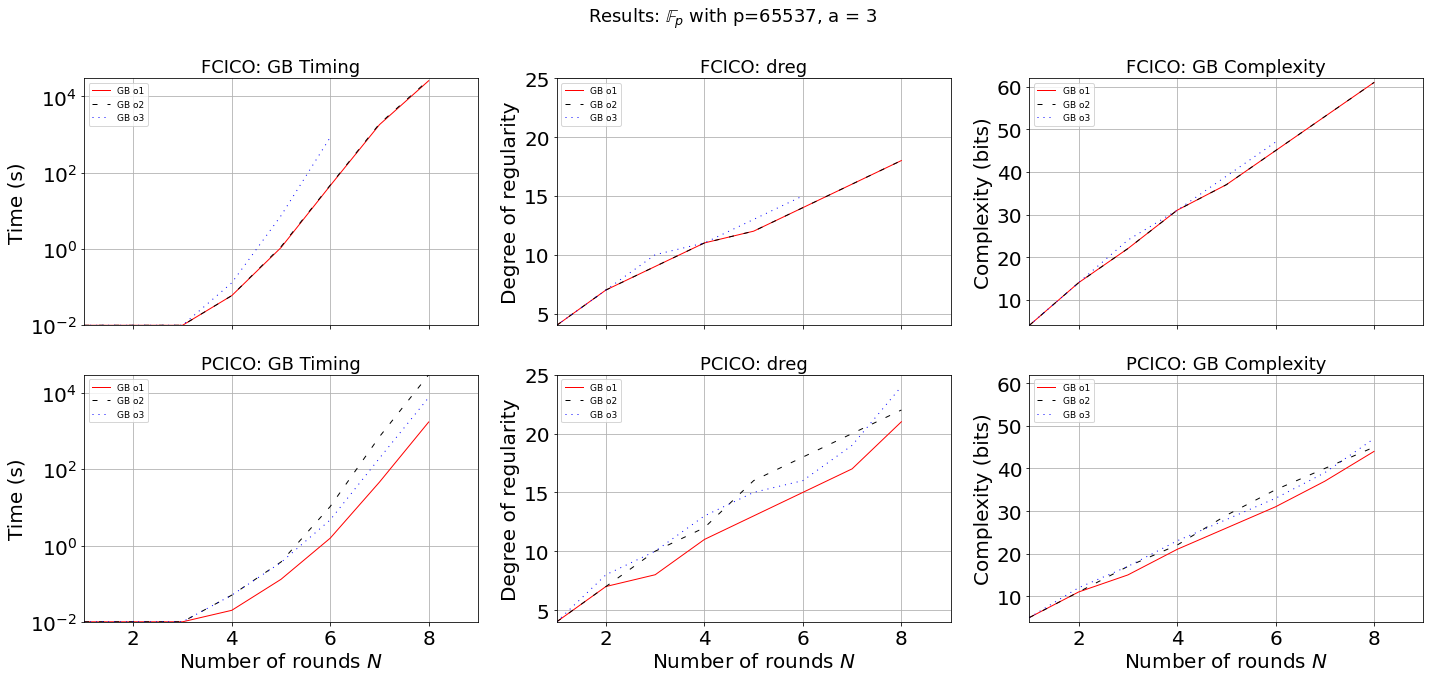

In [9]:
plot_results(results_Fp, alg='GB', p=65537, a=3, saveTables=False) 
# Note the influence of the variable ordering for PCICO

In [10]:
#plot_results(results_Fp, alg='FGLM', p=18446744073709551263, a=3, saveTables=True) 
#plot_results(results_Fp, alg='FGLM', p=4294967087, a=3, saveTables=True) 
# Note the influence of the variable ordering for PCICO 

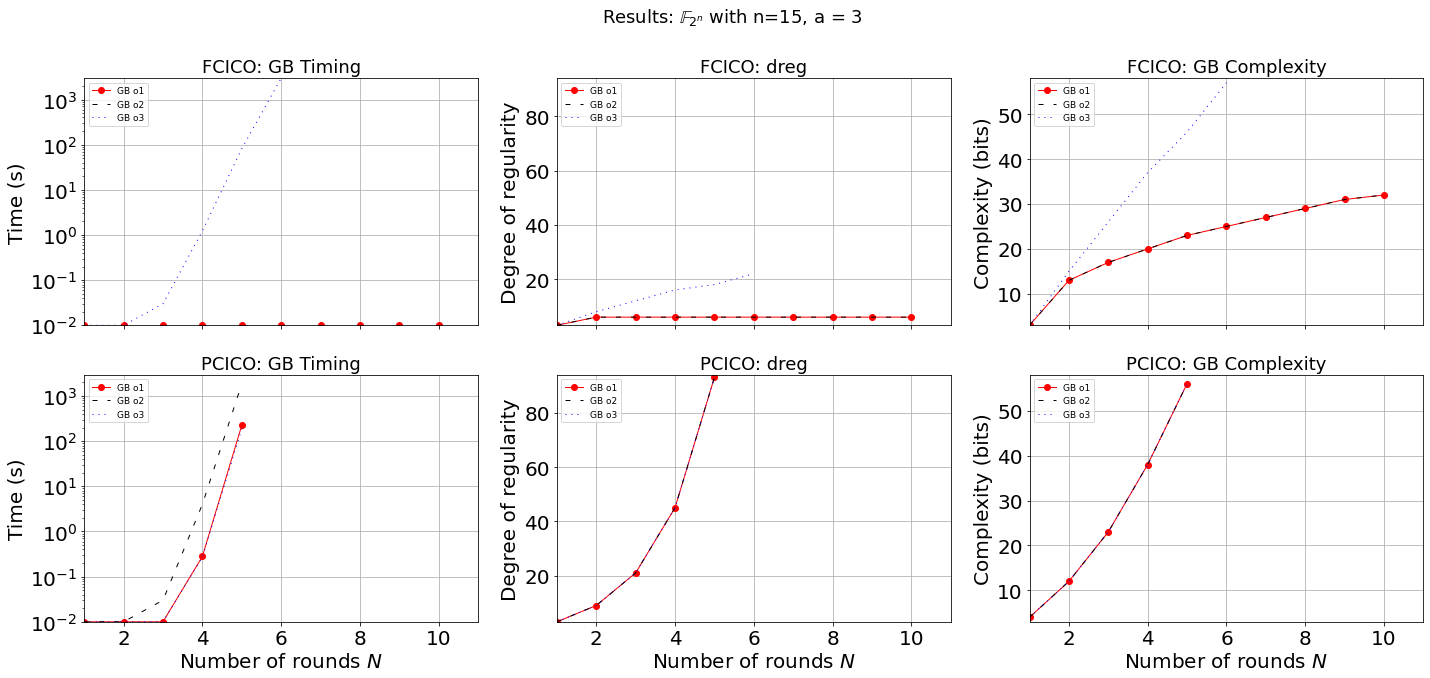

In [11]:
plot_results(results_F2n, alg='GB', p=2, n=15, a=3, markers=['o','',''], saveTables=False)

##### $\alpha = 5$

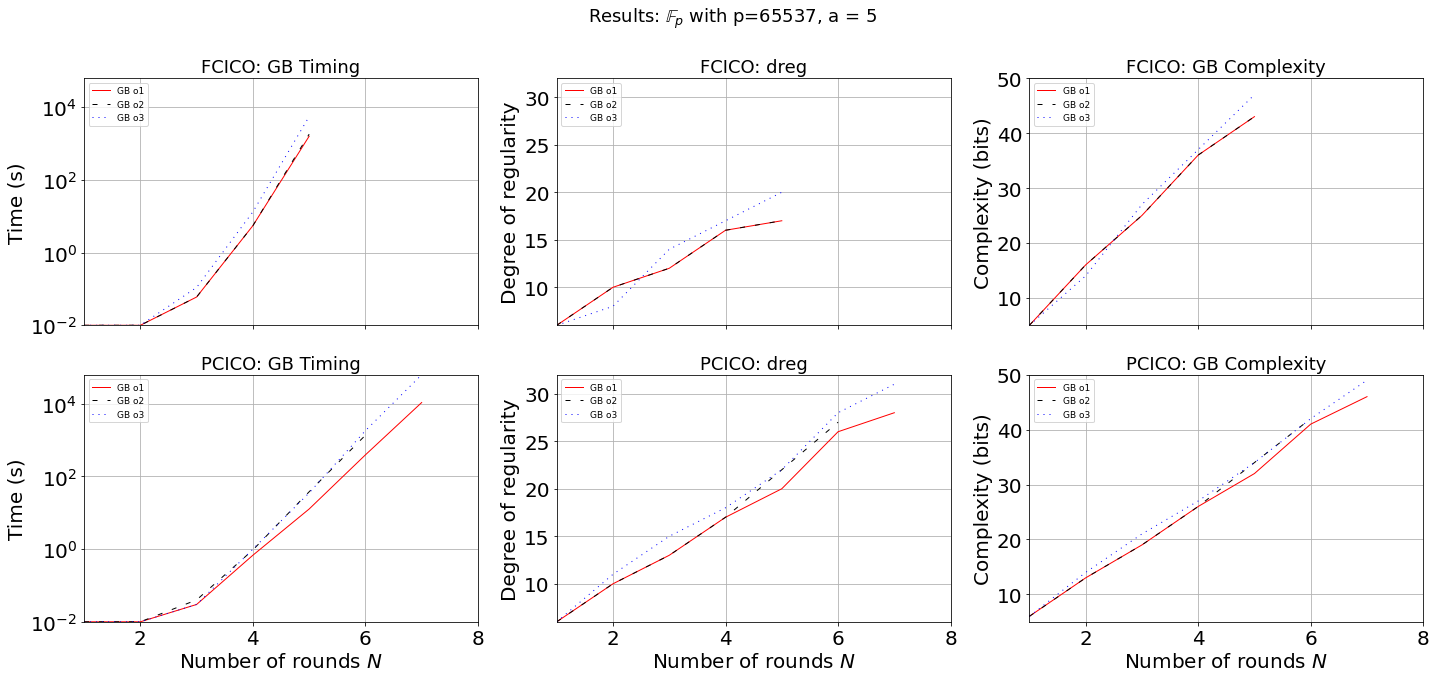

In [12]:
plot_results(results_Fp, alg='GB', p=65537, a=5, saveTables=False) 
# Note the influence of the variable ordering for PCICO

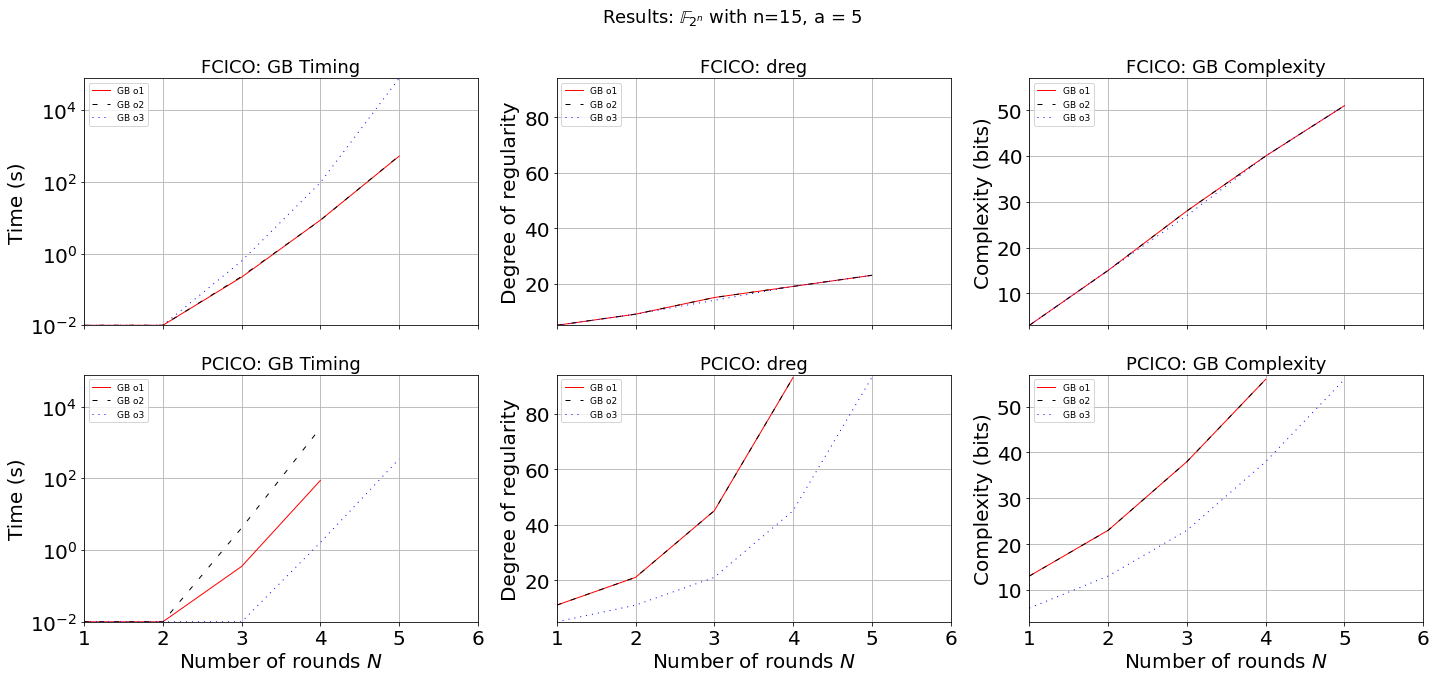

In [13]:
plot_results(results_F2n, alg='GB', p=2, n=15, a=5, saveTables=False)

##### $\alpha = 7$

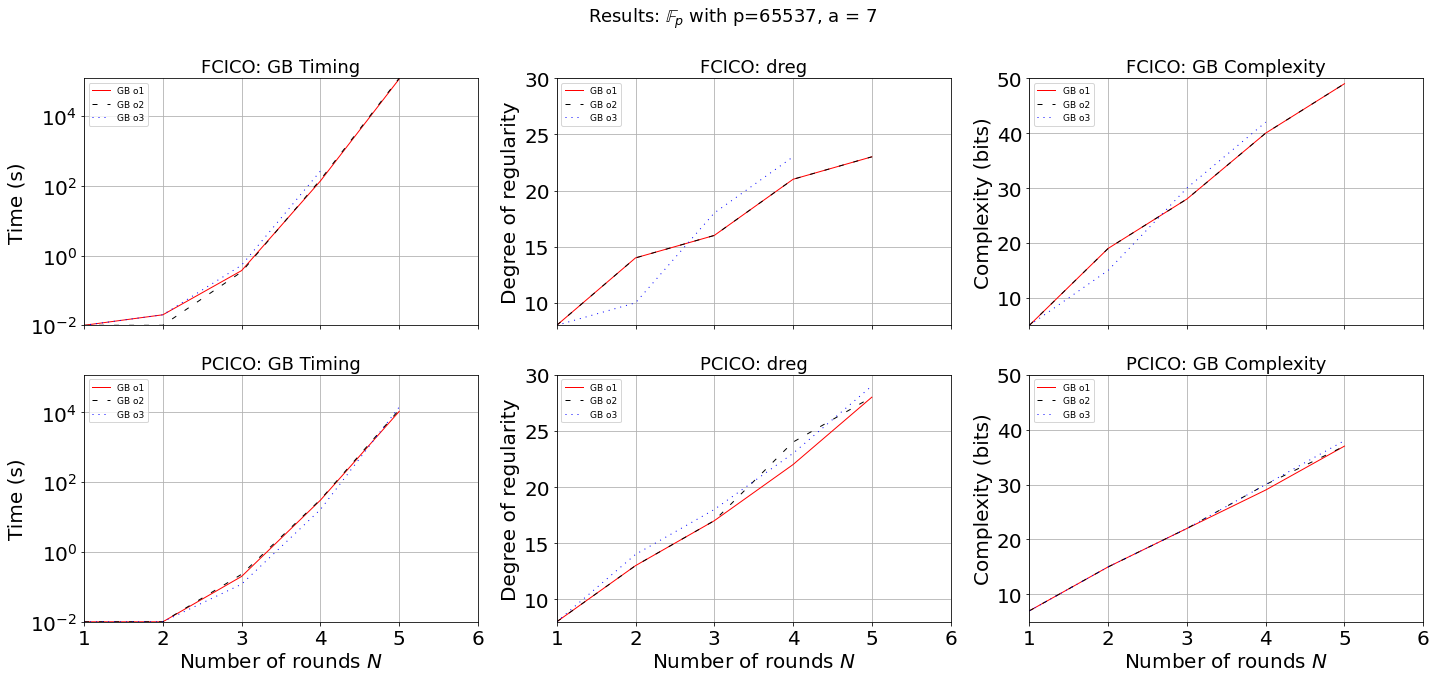

In [14]:
plot_results(results_Fp, alg='GB', p=65537, a=7, saveTables=False) 
# Note the influence of the variable ordering for PCICO

##### $\alpha = 11$

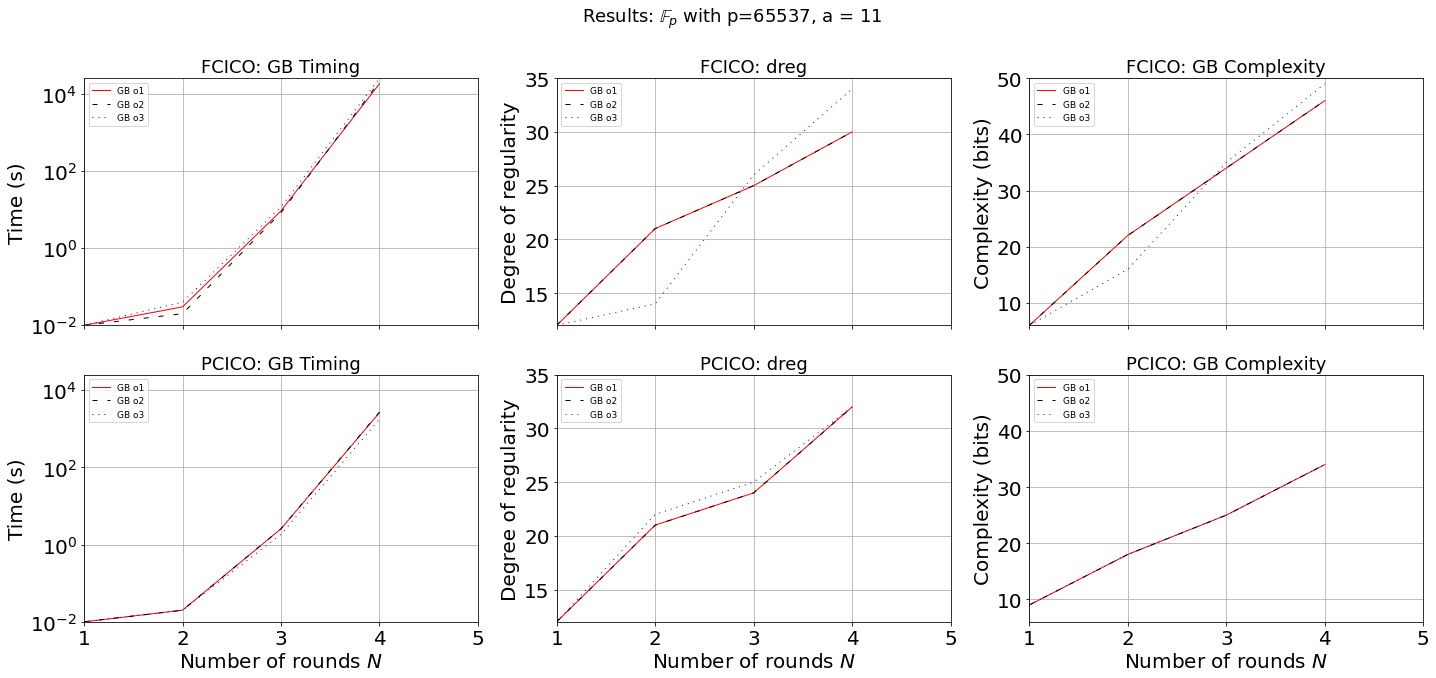

In [15]:
plot_results(results_Fp, alg='GB', p=65537, a=11, saveTables=False) 
# Note the influence of the variable ordering for PCICO

#### Step 2: FGLM basis conversion

##### $\alpha=3$

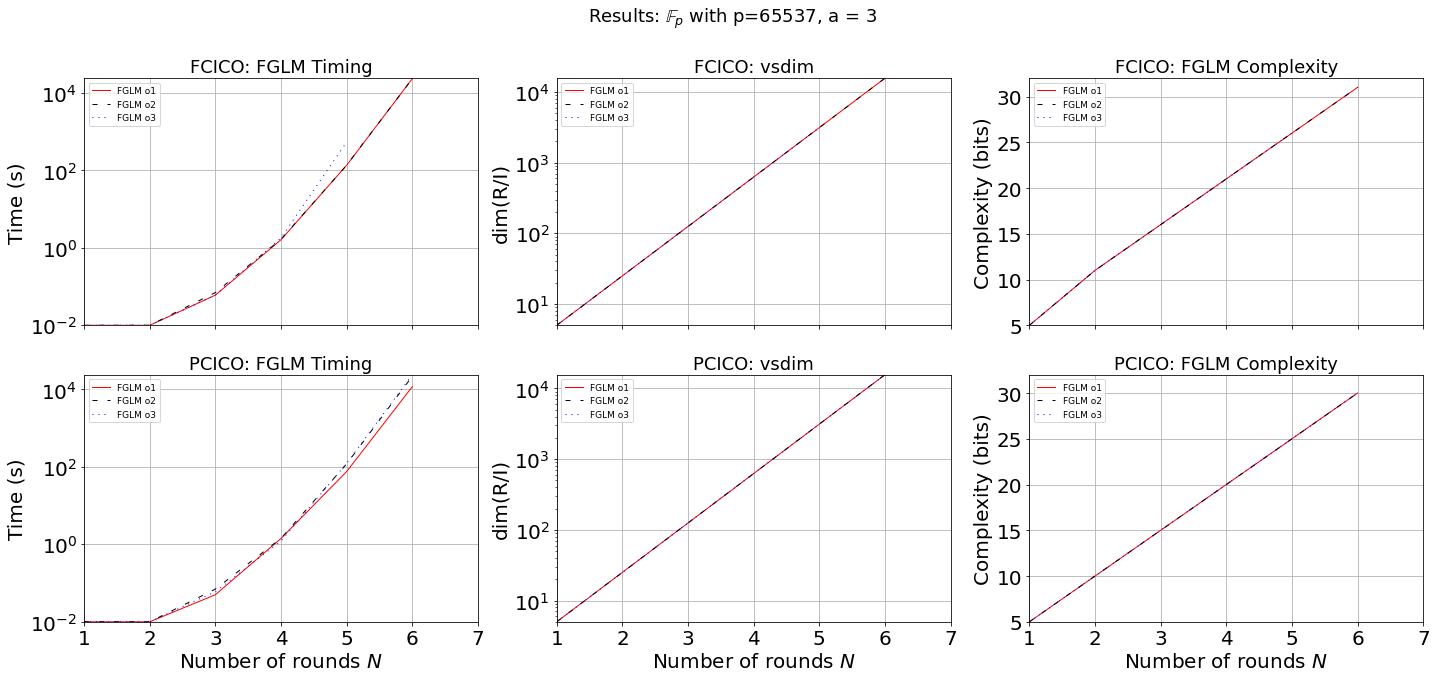

In [16]:
plot_results(results_Fp, alg='FGLM', p=65537, a=3, saveTables=False) 
# No big further influence of the primarily chosen variable ordering

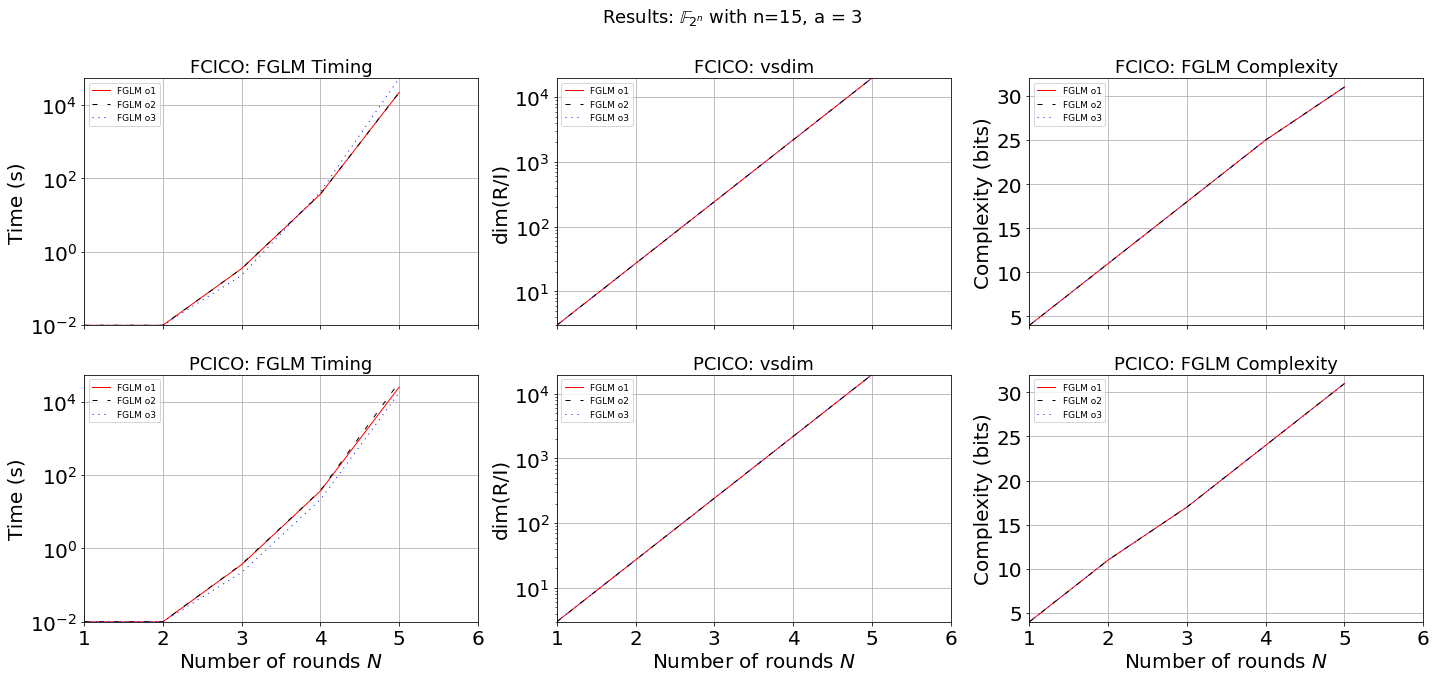

In [17]:
plot_results(results_F2n, alg='FGLM', p=2, n=15, a=3, saveTables=False)

##### $\alpha=5$

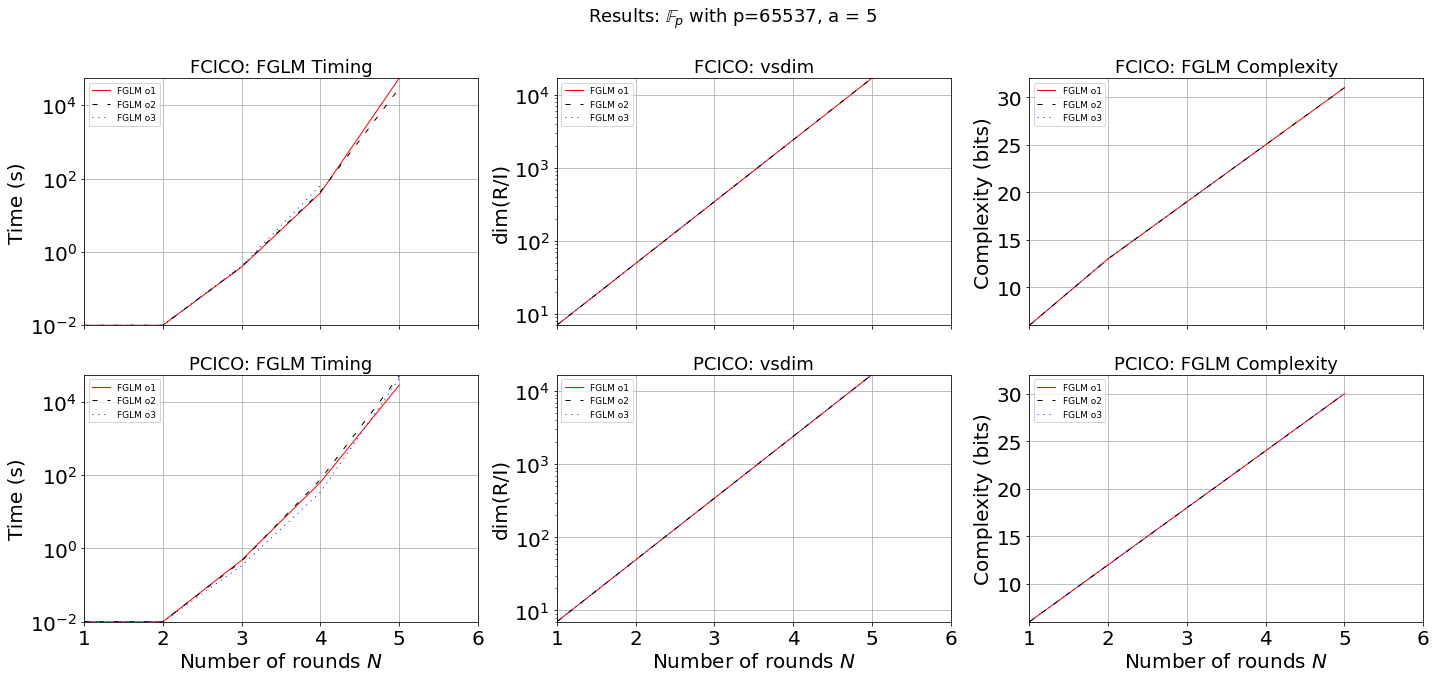

In [18]:
plot_results(results_Fp, alg='FGLM', p=65537, a=5, saveTables=False)

##### $\alpha=7$

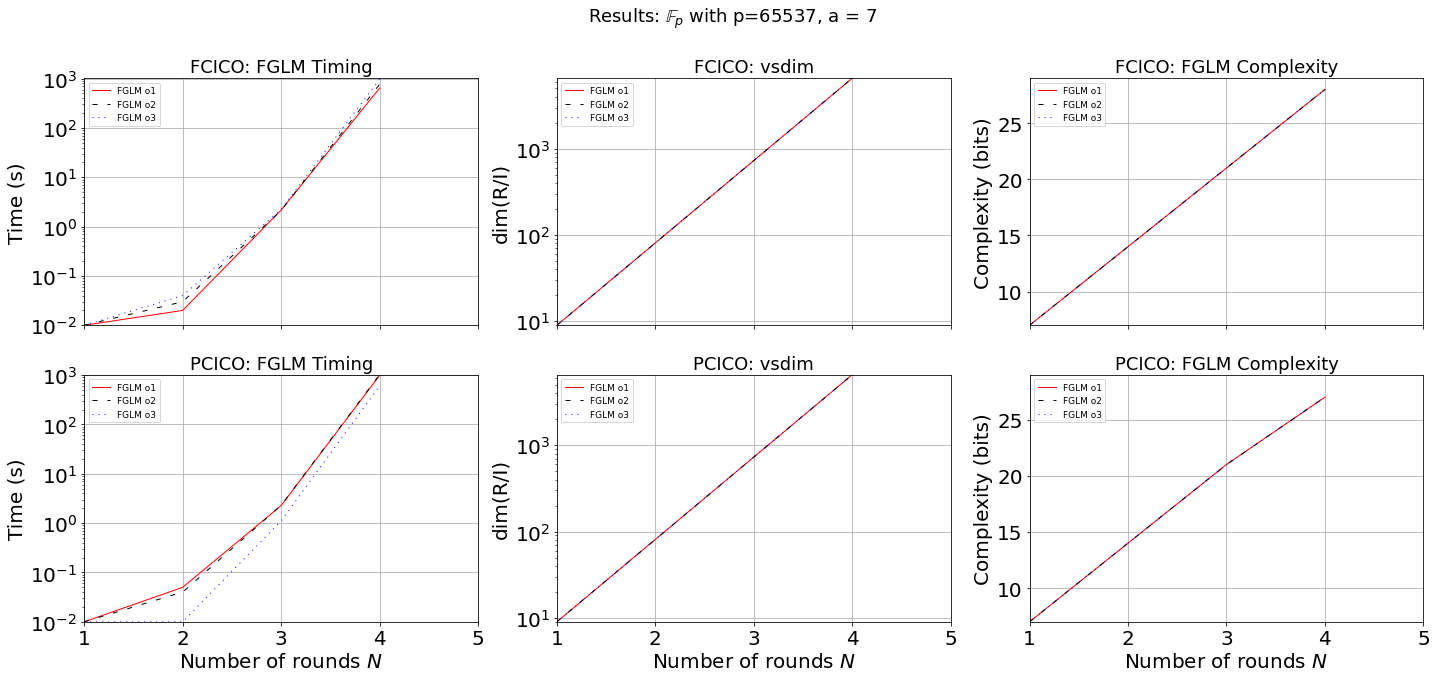

In [19]:
plot_results(results_Fp, alg='FGLM', p=65537, a=7, saveTables=False)

##### $\alpha=11$

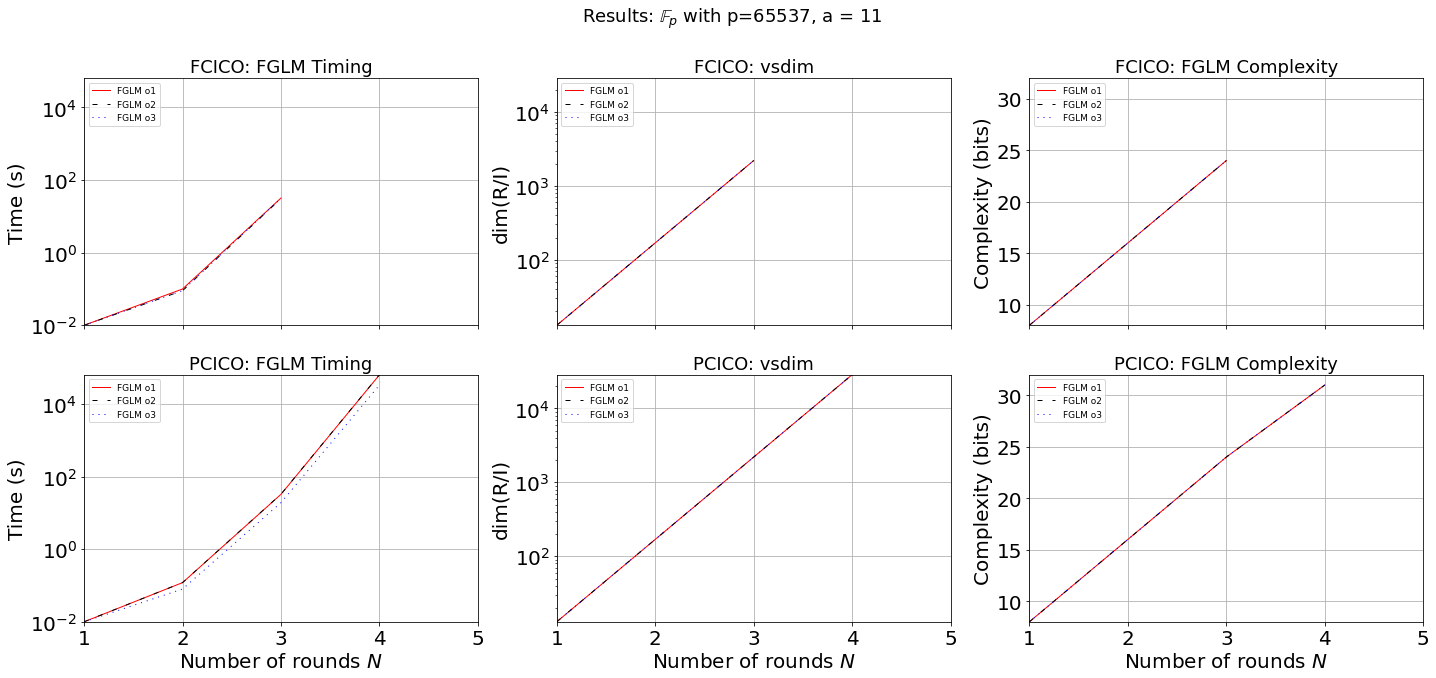

In [20]:
plot_results(results_Fp, alg='FGLM', p=65537, a=11, saveTables=False)

### Working degree evolution

In [21]:
def plot_workind_degrees(results, a=3, N=5, markers=['x','x','x'], linestyle=['solid','dotted','dashed'], linewidth=1, rmin=1, saveFig=False, figname="exp_working_degrees"):
    # One prime per row, 2 columns per row, one for FCICO, one for PCICO. All orderings.
    results_a = {key:results[key] for key in results if a in results[key]}
    
    nrows = len(results_a) # One row for each prime that has data for given alpha=a
    ncols = 2 # Models
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(9 * ncols, 5 * nrows), sharey=False, sharex=False)
    fig.subplots_adjust(hspace=0.5)
    axs = [axs] if nrows == 1 else axs
    
    colors = ['r','g','b']
    
    for r_axs, (p,n) in zip(axs, sorted(results, key=sort_p_n)): # One row for each prime / prime power

        xmin = 1
        xmax = 0
        
        ymin = 100
        ymax = 0
        
        if a not in results[(p,n)]:
            continue
        
        for ax, m in zip(r_axs, sorted(results[(p,n)][a])): # One columns per model
            ax.grid(True)
            
            placeLegend=False
            
            for o in results[(p,n)][a][m]:
                # Ignore if no results for this case
                if (len(results[(p,n)][a][m][o]) < (N-rmin)+1) or (results[(p,n)][a][m][o][N-rmin]['GB']['dreg'] is None):
                    continue
                    
                data = results[(p,n)][a][m][o][N-rmin]
                assert(data['nr'] == N)
                
                y = data['GB']['dregs']
                x = list(IntegerRange(1,len(y)+1))
                ax.add_line(Line2D(x[:len(y)], y, color=colors[o-1], marker=markers[o-1], label=f"o{o}", linewidth=linewidth, linestyle=linestyle[o-1]))   
                
                xmax = max(xmax,max(x))
                ymin = min(ymin,min(y))
                ymax = max(ymax,max(y))
                
                placeLegend=True
            
            ax.set_title(f"{m}, a = {a}, N = {N} (p = {p}, n = {n})")
            ax.set_ylim(ymin-1,ymax+1)
            ax.set_xlim(xmin-1,xmax+1)
            ax.set_xlabel("Iteration")
            ax.set_ylabel("Working degree")
            
            if placeLegend:
                ax.legend(loc=2, fontsize="9")

    if saveFig:
        plt.savefig(f"gfx/{figname}.svg", bbox_inches='tight', dpi=4000)
    else:
        plt.show()

##### $\alpha=3$

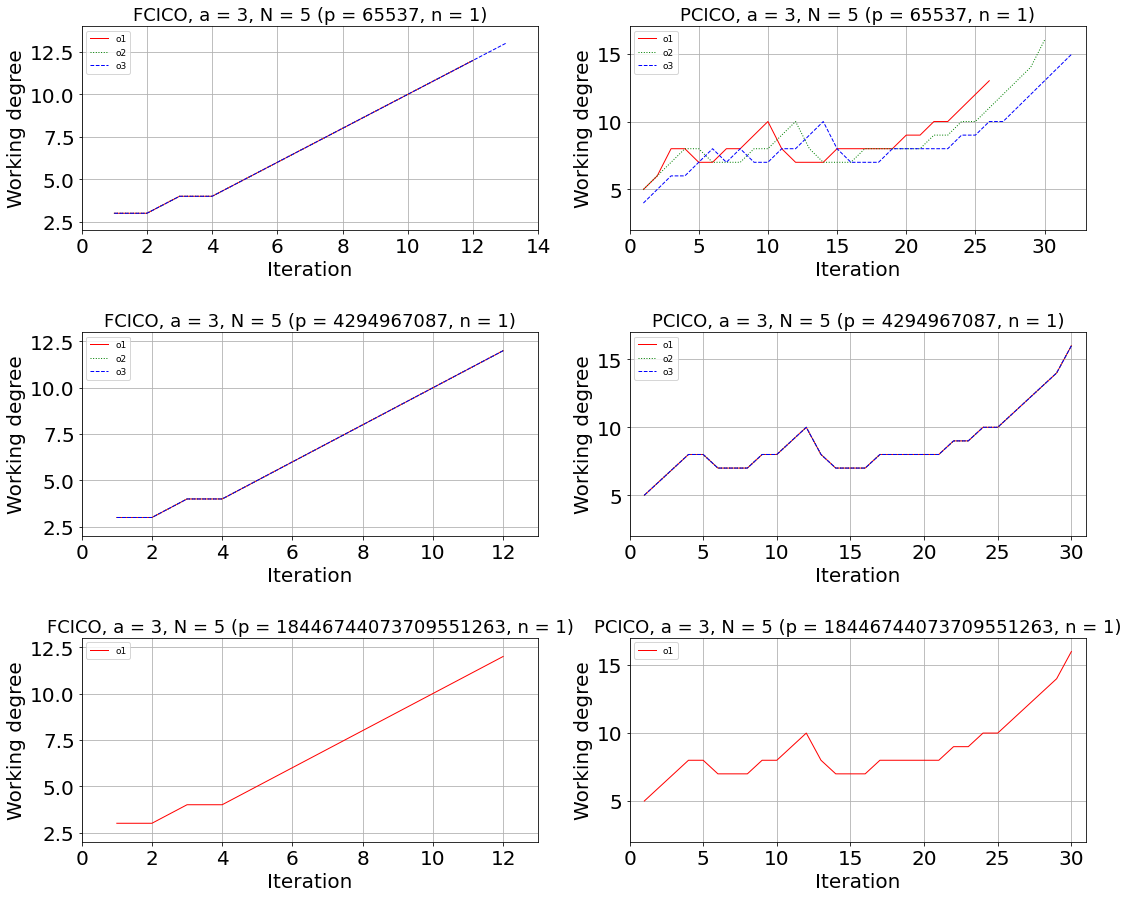

In [22]:
#for r in range(2,6+1):
plot_workind_degrees(results_Fp, a=3, N=5, linestyle=['solid','dotted','dashed'], markers=['','',''])

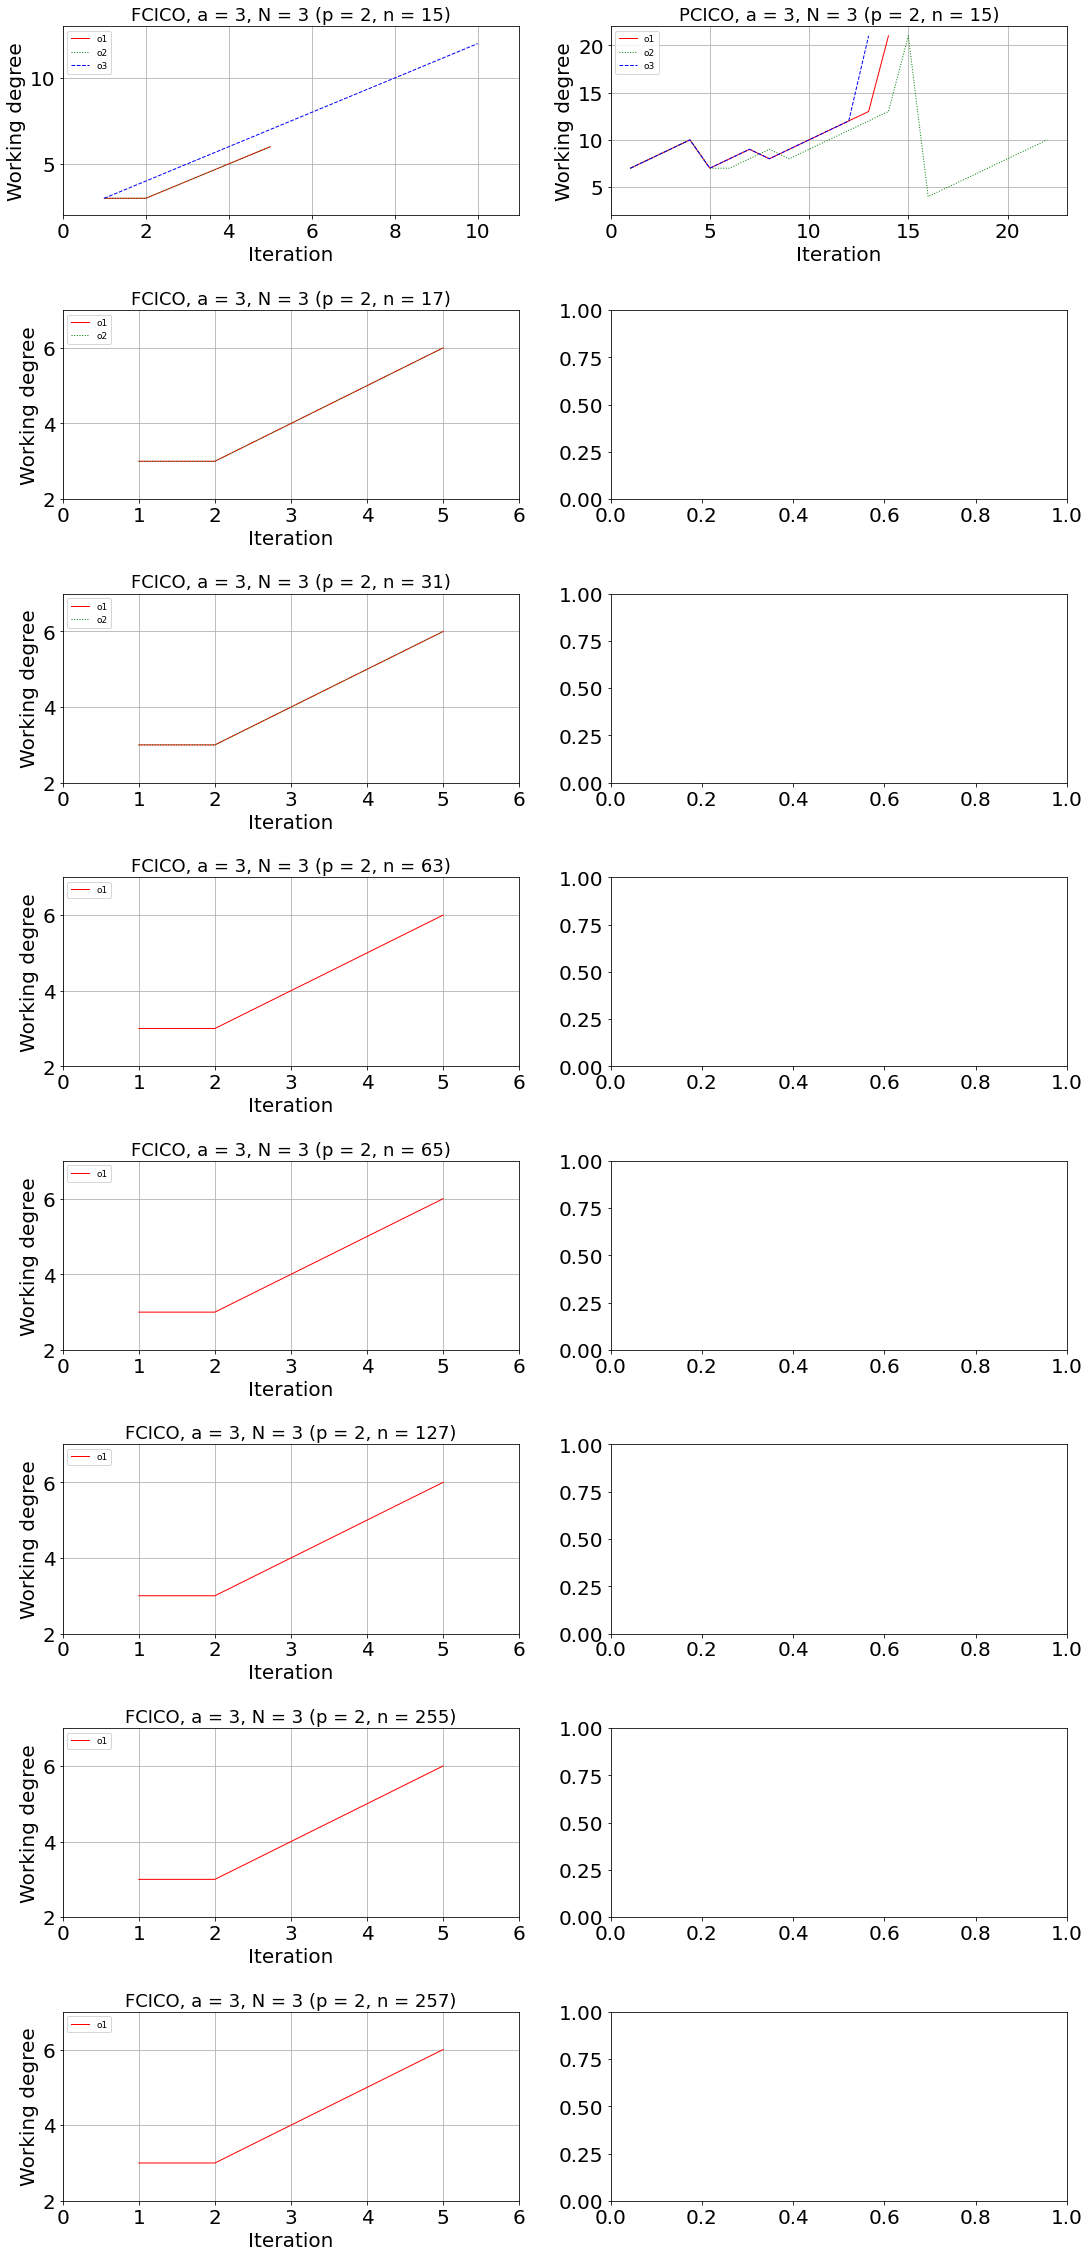

In [23]:
plot_workind_degrees(results_F2n, a=3, N=3, linestyle=['solid','dotted','dashed'], markers=['','',''])

##### $\alpha=5$

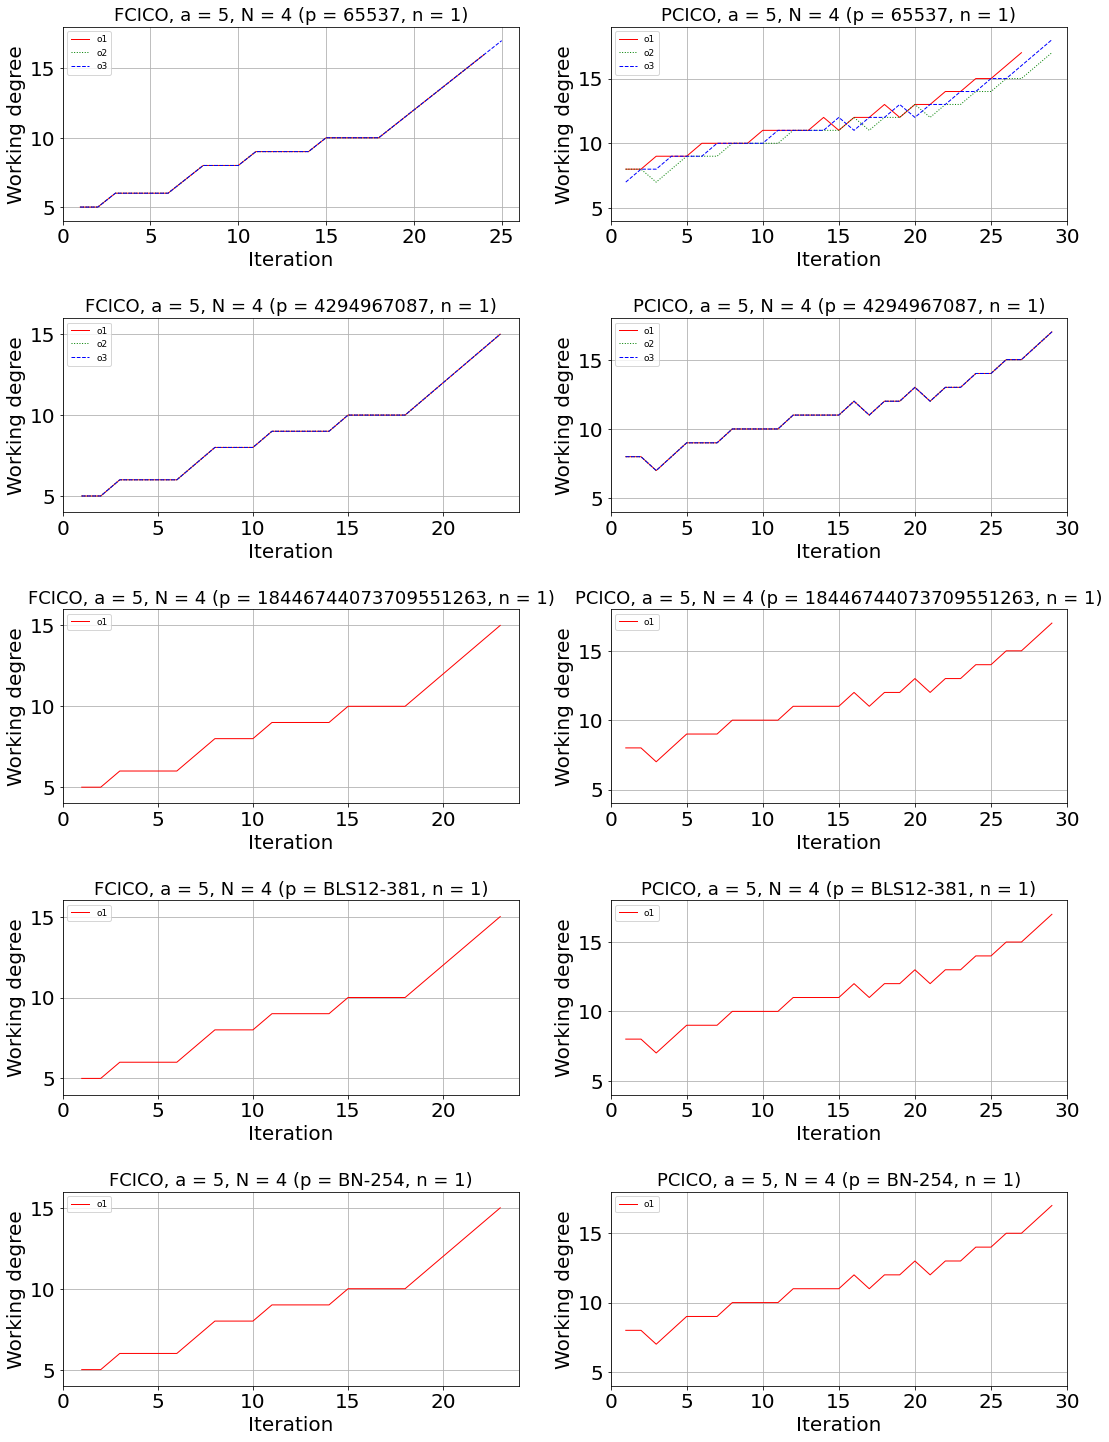

In [24]:
plot_workind_degrees(results_Fp, a=5, N=4, linestyle=['solid','dotted','dashed'], markers=['','',''])

##### $\alpha=7$

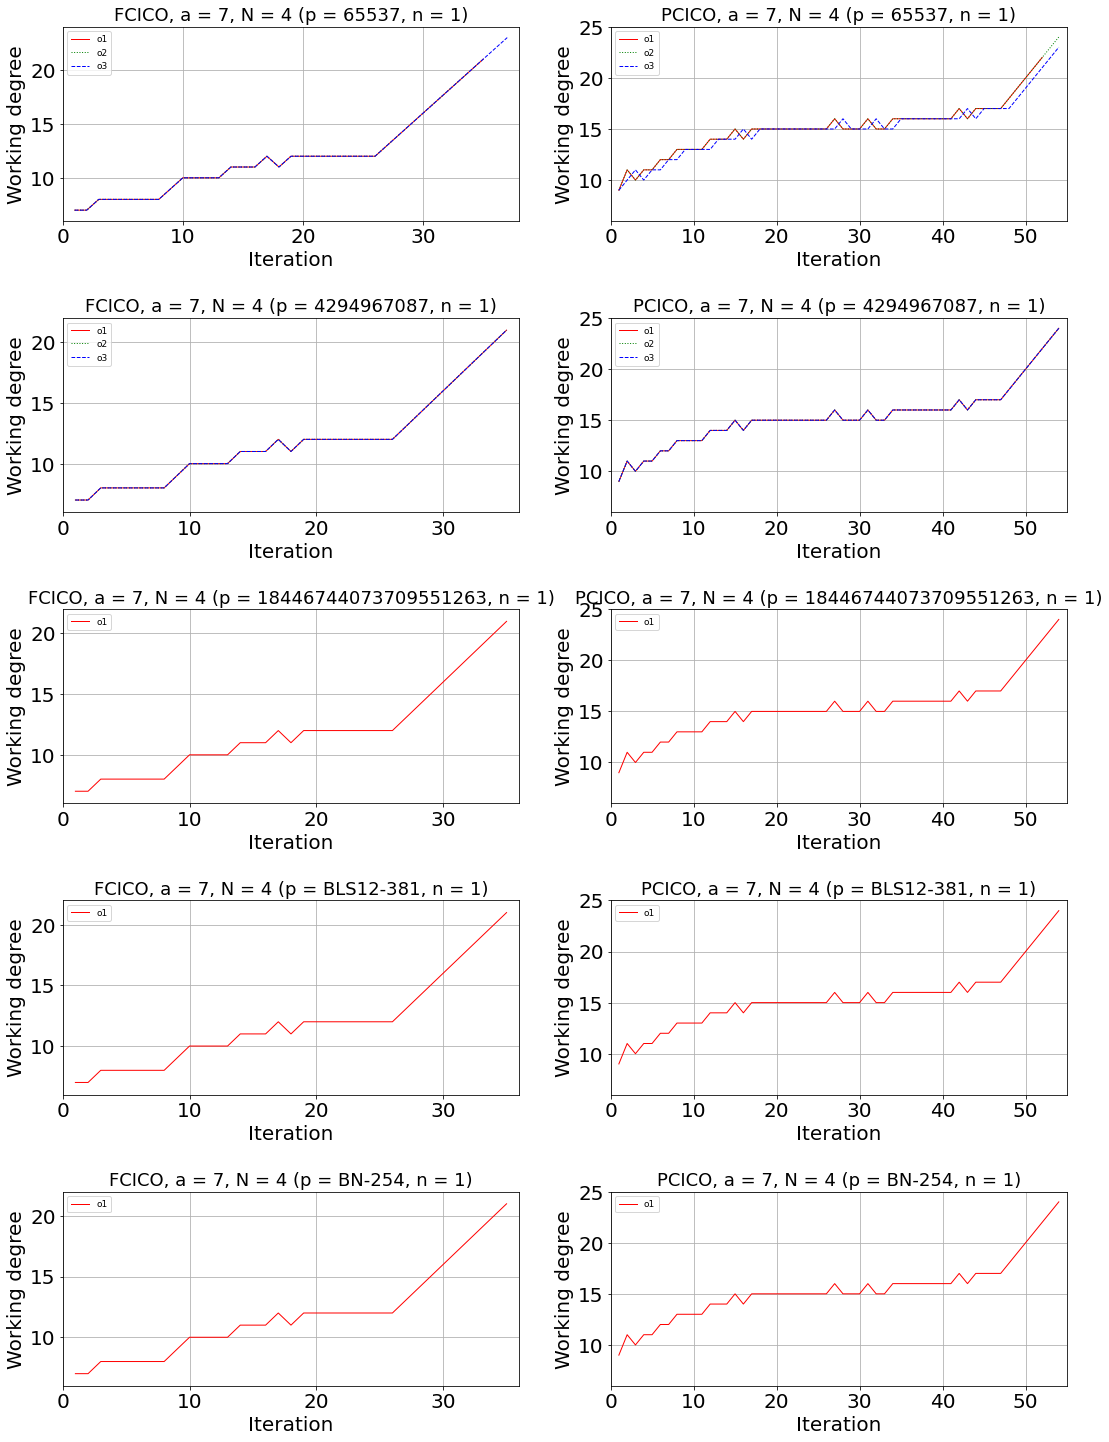

In [25]:
plot_workind_degrees(results_Fp, a=7, N=4, linestyle=['solid','dotted','dashed'], markers=['','',''])

##### $\alpha=11$

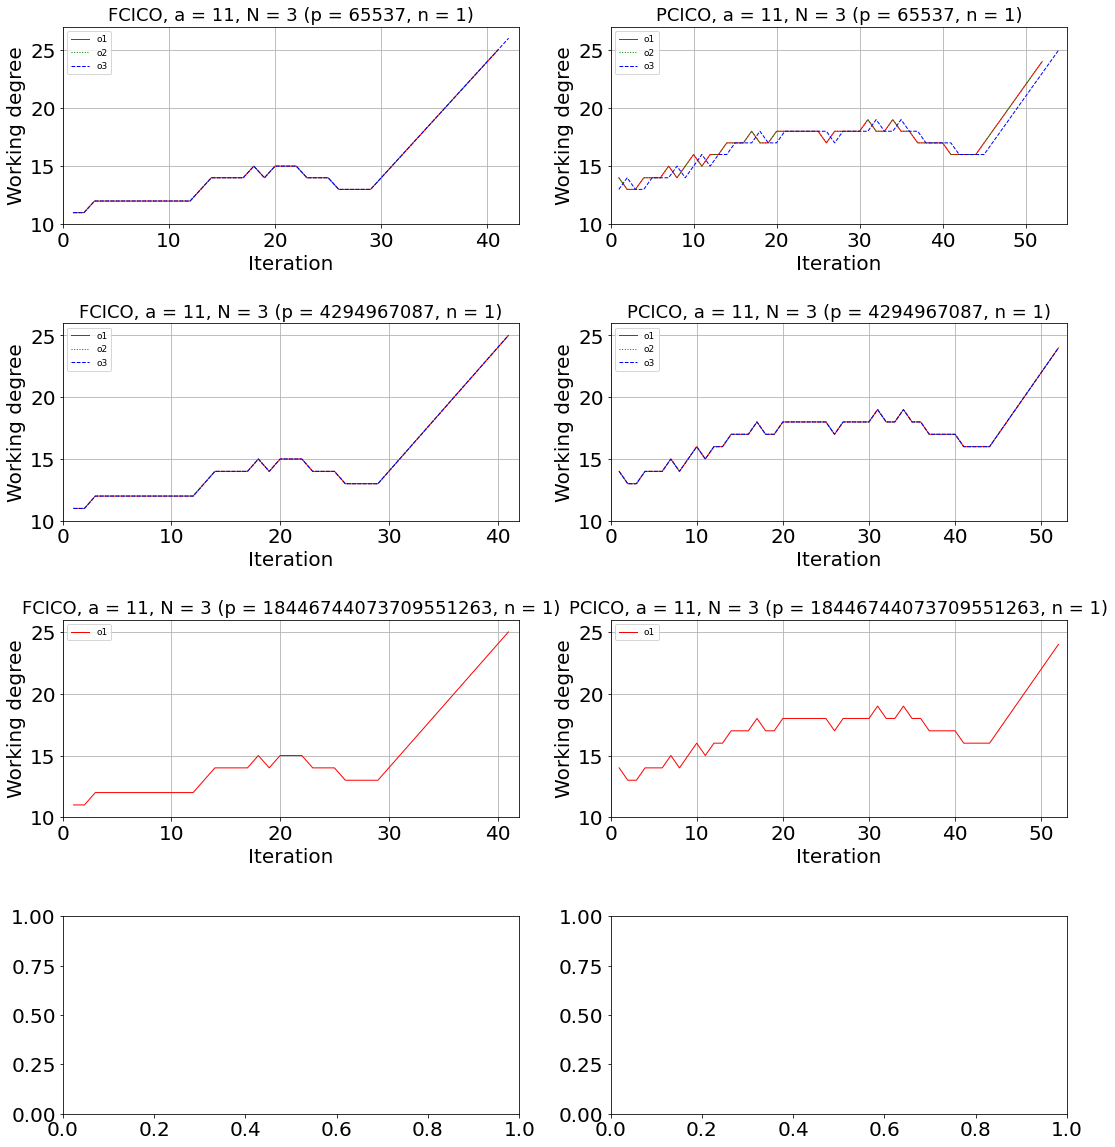

In [26]:
plot_workind_degrees(results_Fp, a=11, N=3, linestyle=['solid','dotted','dashed'], markers=['','',''])

### Comparison metrics over different fields

In [27]:
def plot_metric_comparison(results, alphas=[3,5,7,11], alg='GB', metric = {'GB':'dreg', 'FGLM':'vsdim'}, varord=[1], rmin=1, markers=['x','x','x'], linestyle=['solid','dotted','dashed']):
    # rows: Models
    # columns: Alphas
    
    nrows = len(alphas) #One row for each alpha
    ncols = 2 # One column for each model
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(9 * ncols, 5 * nrows), sharey=False, sharex=False)
    fig.subplots_adjust(hspace=0.3)
    axs = [axs] if nrows == 1 else axs
    
    colors = ['r','b','g','orange','black']
    
    rmax = 0
    
    for r_axs, a in zip(axs, alphas): # One row for each model
        
        for ax, m in zip(r_axs,['FCICO','PCICO']): # one column per alpha
            ax.grid(True)
            
            ax.set_ylabel(metric[alg])
            ax.set_title(f"{m} (a = {a})")
            
            ymin=20
            ymax=0
            
            placeLegend=False
            
            for i, (p,n) in enumerate(sorted(results,key=sort_p_n)):
                
                if a not in results[(p,n)] or m not in results[(p,n)][a] or not any([o in results[(p,n)][a][m] for o in varord]):
                    continue
                
                for o in [v for v in varord if v in results[(p,n)][a][m]]:
                    y = [d[alg][metric[alg]] for d in results[(p,n)][a][m][o]]
                    y = [d for d in y if (d != -1 and d != None)] # Exclude not present data
                    y = [yi if yi > 0.01 else 0.01 for yi in y] # Replace very small timings because of log axis (only relevant for timing)
                    x = list(IntegerRange(rmin,len(y)+rmin))

                    ax.add_line(Line2D(x[:len(y)], y, color=colors[i%len(colors)], label=f"{'p='+(hex(p) if isinstance(p,int) else p) if n==1 else 'n='+str(n)}, o{o}", 
                                       linestyle=linestyle[o-1],linewidth=1))   
                    ymin, ymax = min(ymin,min(y)), max(ymax, max(y))
                    rmax = max(rmax,x[-1])

                    placeLegend = True

            ax.set_ylim(ymin, ymax+1)
            ax.set_ylabel(metric[alg])
            ax.set_xlabel("Number of rounds $N$")
            ax.set_title(f"{m} (a = {a})")
            ax.set_xlim(rmin-1, rmax+1)
            
            if metric[alg] == 't':
                ax.set_yscale('log', base=10)
            if metric[alg] == 'vsdim':
                ax.set_yscale('log', base=(a+2) if n == 1 else a)
            
            if placeLegend:
                ax.legend(loc=4, fontsize="9")
            
    ax.set_xlim(rmin, rmax+1)

    plt.show()

#### $\mathbb{F}_p$

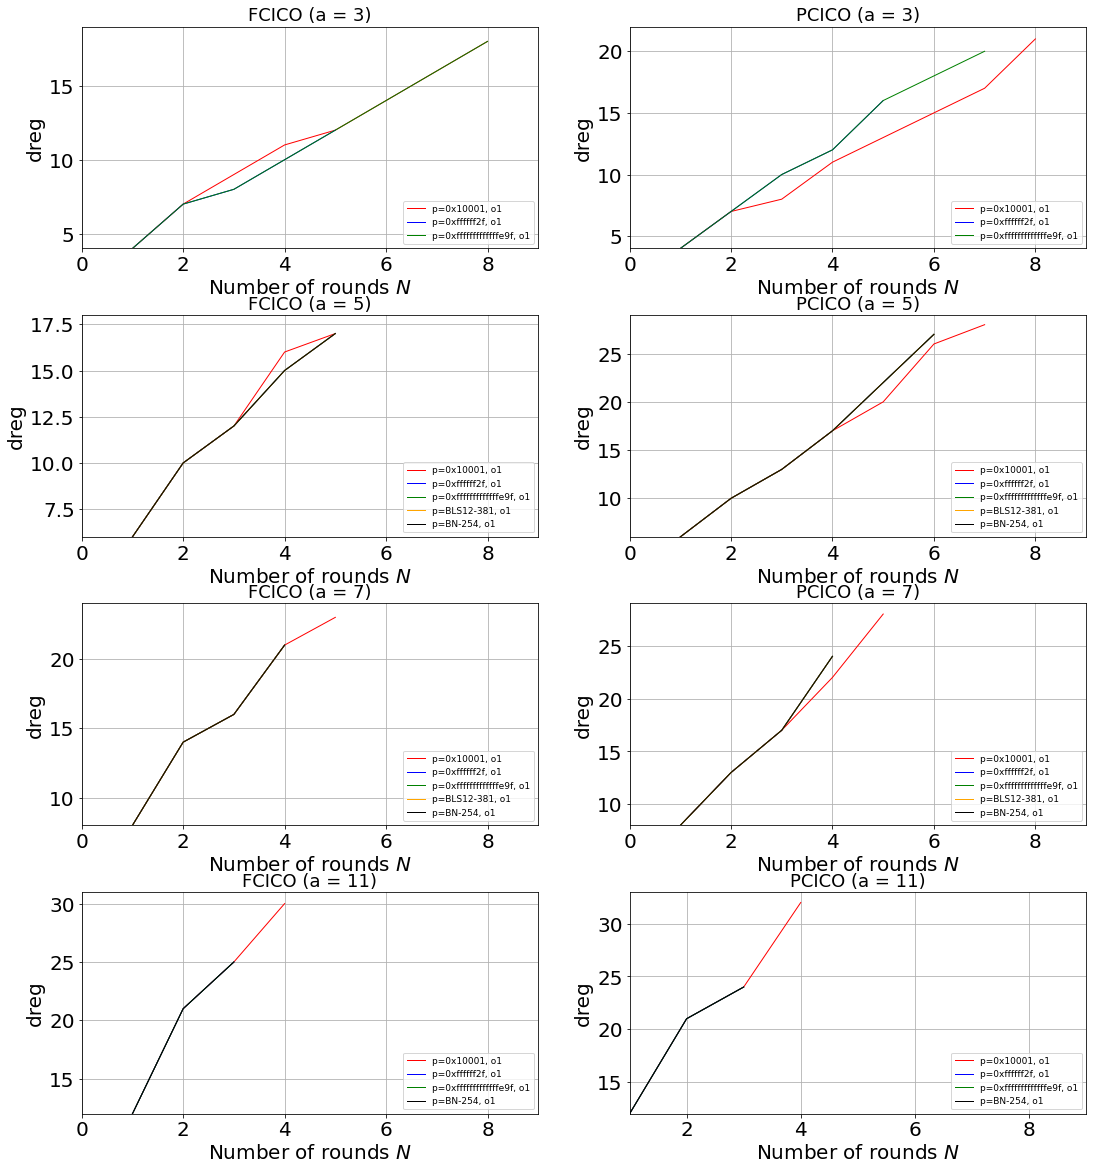

In [28]:
plot_metric_comparison(results_Fp, alg='GB', varord=[1])

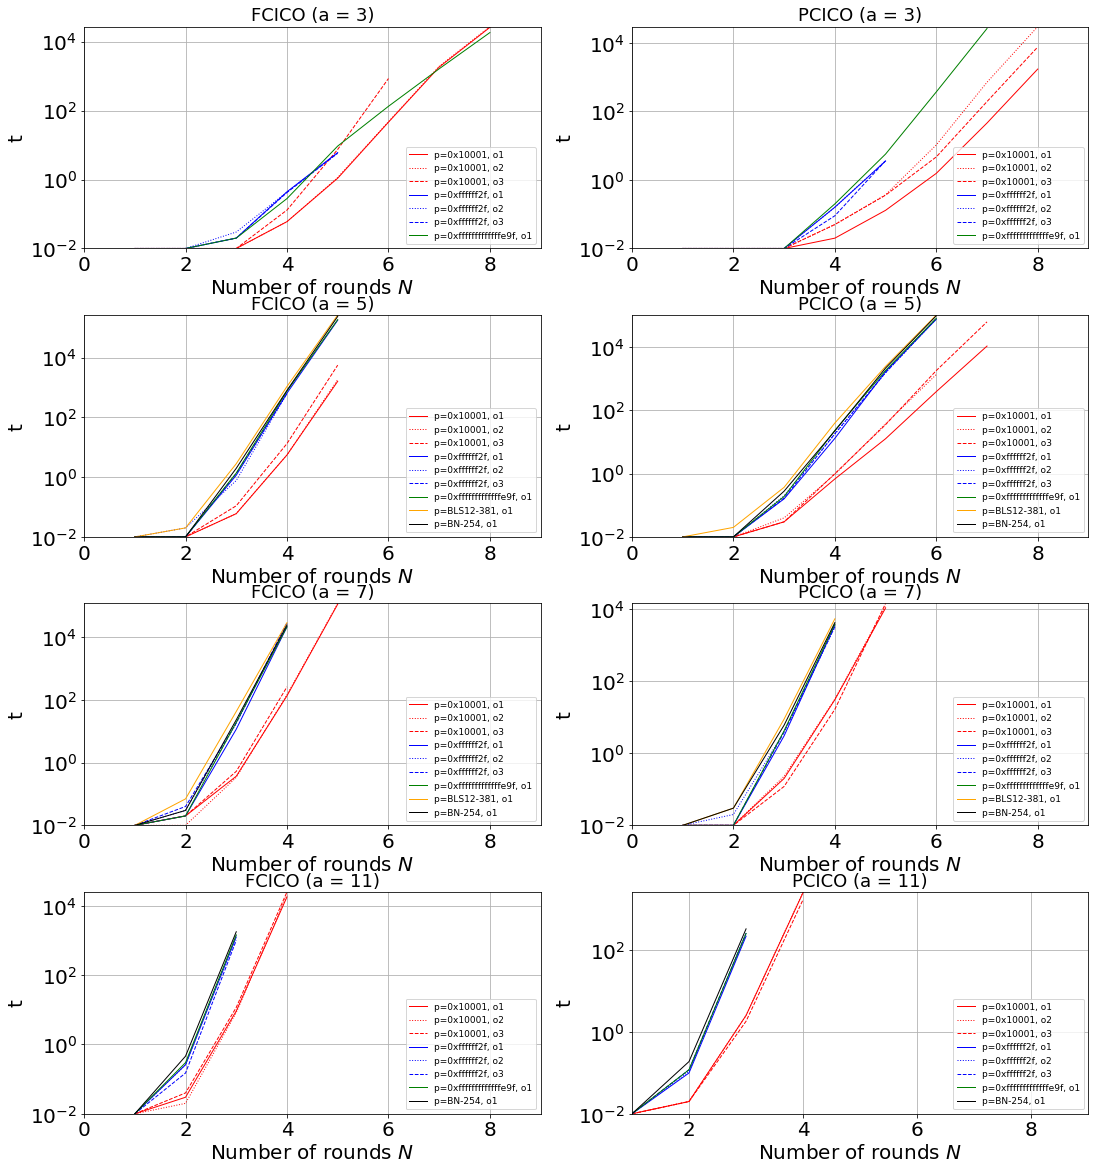

In [29]:
plot_metric_comparison(results_Fp, alg='GB', metric={'GB':'t', 'FGLM':'t'}, varord=[1,2,3])

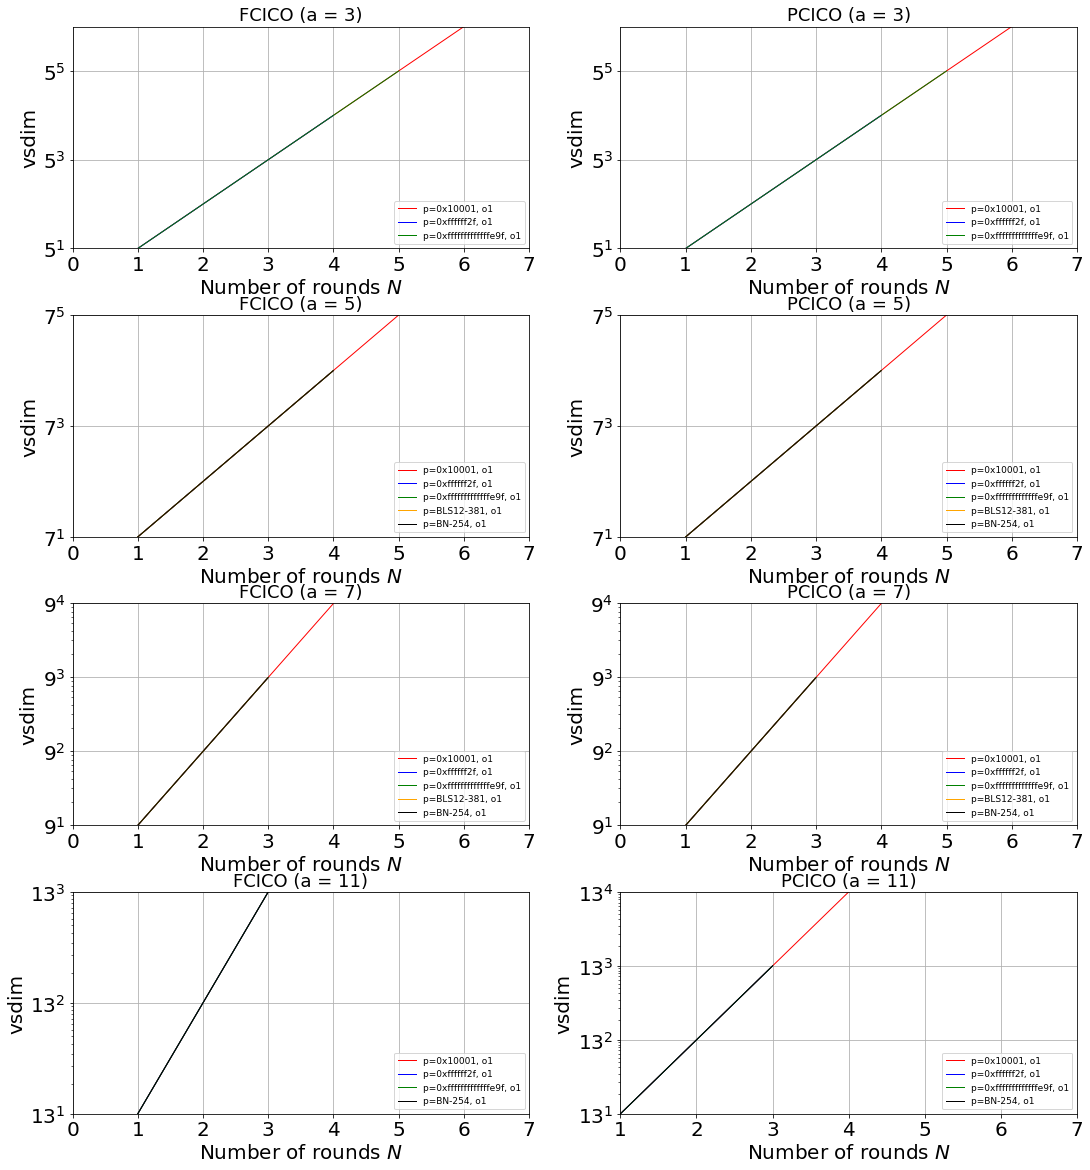

In [30]:
plot_metric_comparison(results_Fp, alg='FGLM')

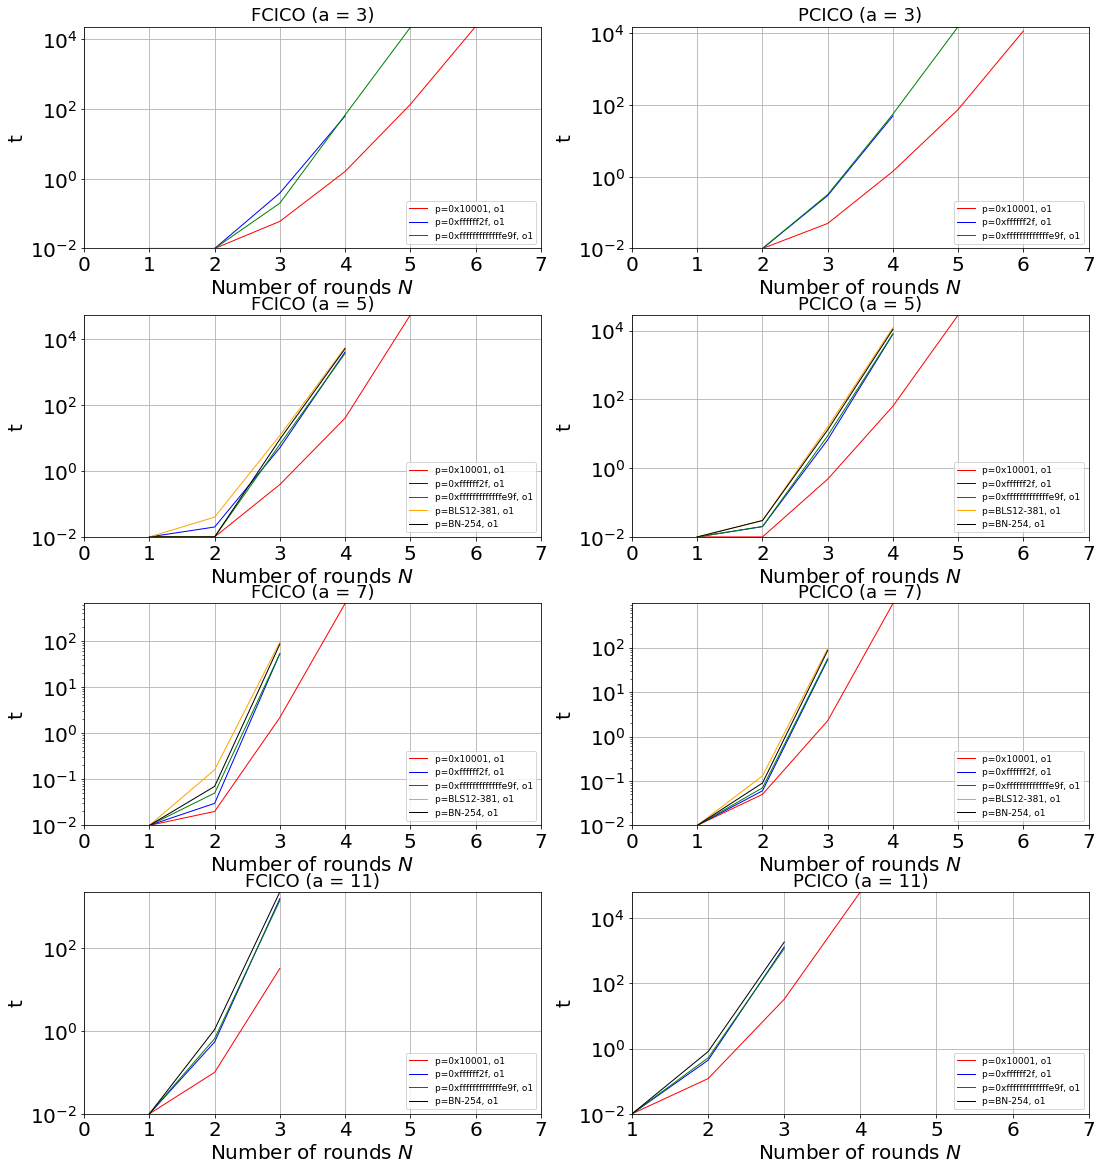

In [31]:
plot_metric_comparison(results_Fp, alg='FGLM', metric={'GB':'t', 'FGLM':'t'})

#### $\mathbb{F}_{2^n}$

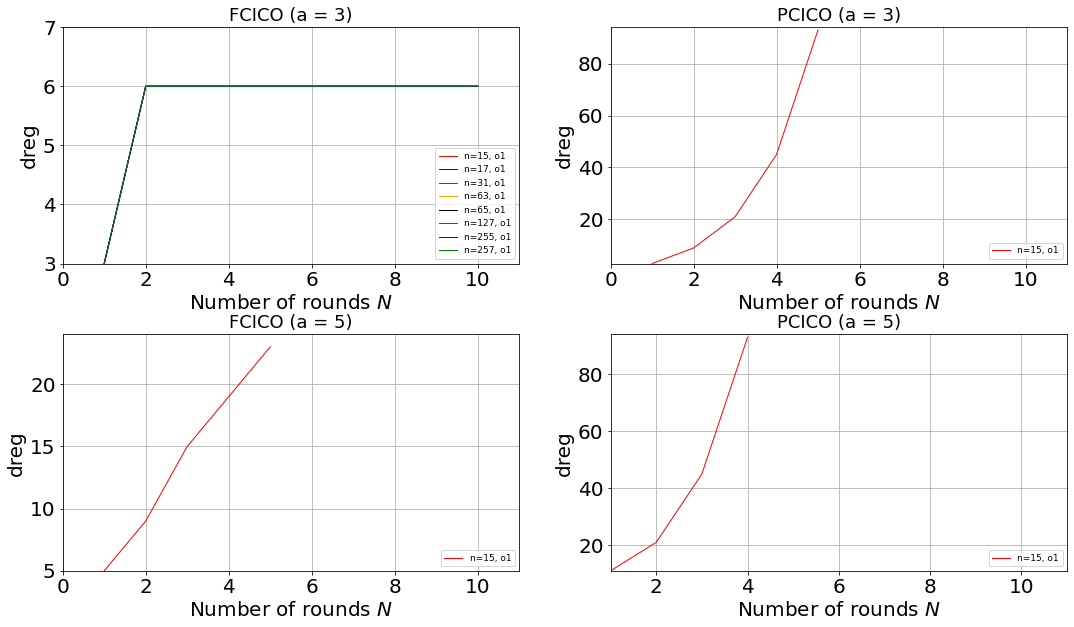

In [32]:
plot_metric_comparison(results_F2n, alg='GB', alphas=[3,5]) # dreg for FCICO constant only for a=3

# Experimental conjectures and theoretical bounds $(\mathbb{F}_p)$

In [33]:
load('anemoi.sage') # Here the class to create Anemoi permutation is stored
load('models.sage') # Here the two models (FCICO,PCICO) are implemented
load('modelBounds.sage')  # Here the results of the below investigations are saved

### GB: Macaulay Bound

In [34]:
fun_mac_PCICO_explicit = lambda N, alpha: alpha*N+1 if N < r_alpha(alpha) else ((alpha-1)/2)**2 + N^2 + N + 1
all([all([fun_mac_PCICO(N,alpha) == fun_mac_PCICO_explicit(N,alpha) for N in range(1,20)]) for alpha in [3,5,7,11]])

True

In [35]:
def save_dreg_data_to_file(x,y,title,filename,spec):
    f = open(f"tables/{filename}", spec)
    f.write("-"*100 + "\n")
    f.write(title + "\n")
    f.write("-"*100 + "\n")
    for xi,yi in zip(x,y):
        f.write(f"{xi} {yi}\n")
    f.write('\n')
    f.close()

def plot_dreg(results, saveTables=False, alphas=[3,5,7,11], keys=[(65537,1)], marker='x', rmin=1, rmax=20, linewidth=1, varord=1, saveFig=False, figname="dreg"):
    # One prime per row, 2 columns per row, one for FCICO, one for PCICO. All orderings.
    nrows = len(alphas)
    ncols = 2 # Models
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(8 * ncols, 5 * nrows), sharey=False, sharex=False)
    #fig.suptitle(f"Step 1: GB computation")
    axs = [axs] if nrows == 1 else axs
    
    colors = ['r','orange','green']
    
    for r_axs, a in zip(axs,alphas):
        
        filename=f"approx_dreg_{a}.txt"
        if saveTables:
            save_dreg_data_to_file([],[],f"Apprxoimation vsdim (a={a})",filename,"w")
            
        for ax, m in zip(r_axs, ['FCICO','PCICO']): # One columns per model
            
            if saveTables:
                save_dreg_data_to_file([],[],m,filename,"a")
                
            ymin = 100
            ymax = 0

            # Add Macaulay bound to plot
            x = list(IntegerRange(1,rmax+1))
            y = [eval(f"fun_mac_{m}({r},{a})") for r in x]
            ax.add_line(Line2D(x[:len(y)], y, color='b', label=f"Mac", linestyle='solid'))
            ymin = min(ymin,min(y))
            ymax = max(ymax,max(y))
            
            if saveTables:
                save_dreg_data_to_file(x,y,"Macaulay",filename,"a")

            # Extrapolated dreg
            for i, f in enumerate(fun_dreg_approx[m]):
                y = [f(r,a) for r in x]
                ax.add_line(Line2D(x[:len(y)], y, color=colors[i], label=title_dreg_approx[m][i], linestyle='dotted'))
                ymin = min(ymin,min(y))
                ymax = max(ymax,max(y))
                
                if saveTables:
                    save_dreg_data_to_file(x,y,title_dreg_approx[m][i],filename,"a")
            
            # Add experimental data to plot
            markers = ['s'] + ['x']*len(keys)
            for i, key in enumerate(sorted(keys,key=sort_p_n)):
                if key in results and a in results[key] and m in results[key][a] and varord in results[key][a][m]:
                    y = [d['GB']['dreg'] for d in results[key][a][m][varord]] # Ord 1 is good ordering for both
                    y = [d for d in y if (d is not None) and (d != -1)]
                    x = list(IntegerRange(1,len(y)+1))

                    ax.add_line(Line2D(x[:len(y)], y, color='k', marker=markers[i], fillstyle='none',
                                       label=f"True {key}", linestyle=''))
                    ymin = min(ymin,min(y))
                    ymax = max(ymax,max(y))
                    
                    if saveTables:
                        save_dreg_data_to_file(x,y,f"Experimental data points: p = {key[0]}^{key[1]}",filename,"a")
            
            # Add r_alpha line
            if m == 'PCICO':
                ax.axvline(x=r_alpha(a), color='k', linestyle='dotted', linewidth=0.5, label="$r_{\\alpha}$")
                if saveTables:
                        save_dreg_data_to_file([],[],f"ra = {r_alpha(a)}",filename,"a")
                        
            # Axis settings
            ax.set_title(f"{m} for $\\alpha = {a}$")
            ax.set_ylim(ymin-1,ymax+1)
            ax.set_xlim(rmin-1,rmax)
            ax.legend(loc=2, fontsize="9")
            #ax.set_yscale('log')
    
    
    xlabel="Number of rounds $N$"
    ylabel="Approximation $d_{reg}$"
    
    if nrows > 1:
        if ncols > 1:
            plt.setp(axs[-1, :], xlabel=xlabel)
            plt.setp(axs[:, 0], ylabel=ylabel)
        else:
            plt.setp(axs[-1], xlabel=xlabel)
            plt.setp(axs[:], ylabel=ylabel)
    else:
        if ncols > 1:
            plt.setp(axs[:], xlabel=xlabel)
            plt.setp(axs[0], ylabel=ylabel)
        else:
            plt.setp(axs, xlabel=xlabel)
            plt.setp(axs, ylabel=ylabel)

    if saveFig:
        plt.savefig(f"gfx/{figname}.svg", bbox_inches='tight', dpi=4000)
    else:
        plt.show()

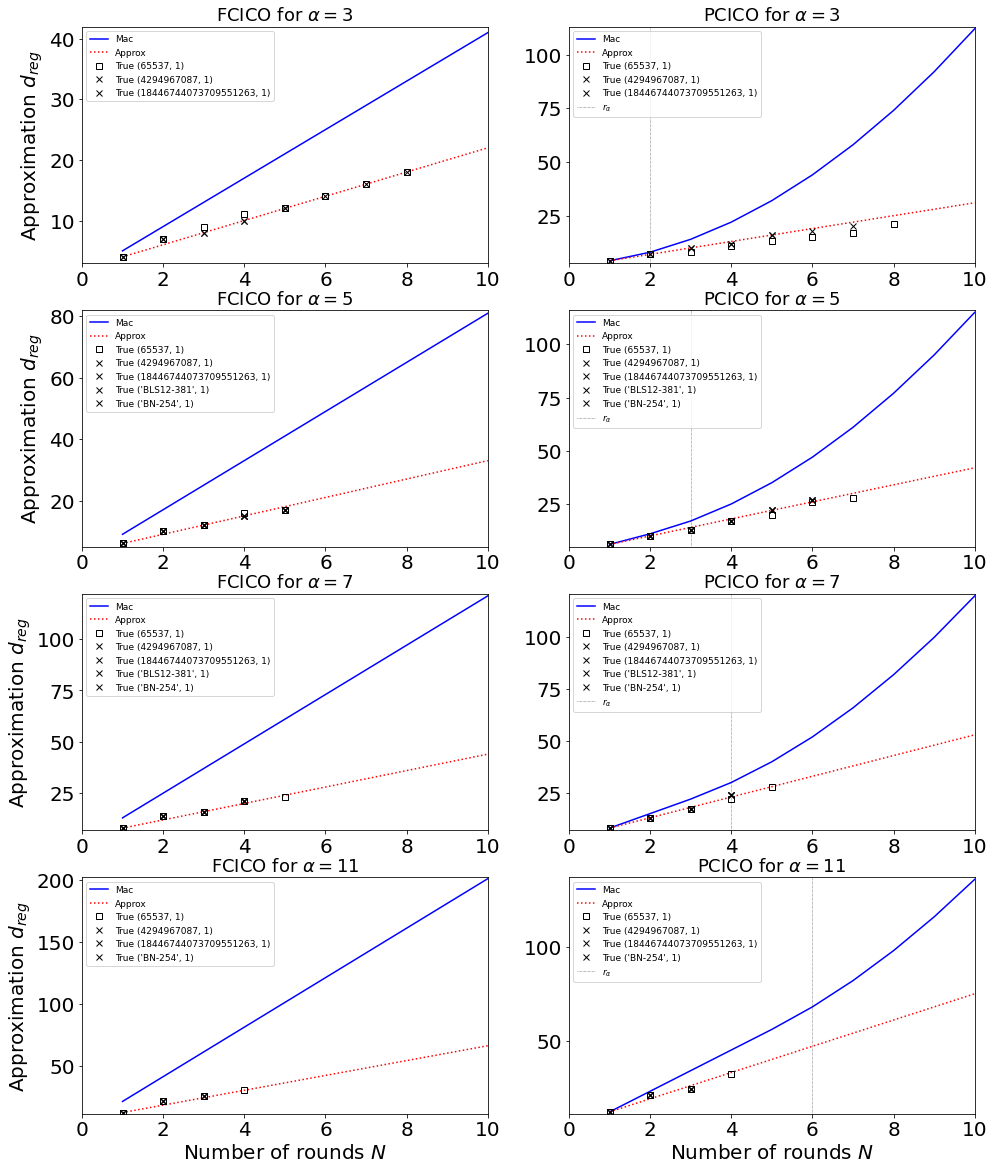

In [36]:
plot_dreg(results_Fp, saveTables=False, alphas=[3,5,7,11], keys=results_Fp.keys(), rmax=10, varord=1)

### (T2) FGLM: Multihomogeneous Bézout

In [37]:
load('SystemAnalysis.sage')  # Tools for multihomogeneous Bézout bound

#### Derivation

In [38]:
def findBestPartition(p, n, l, a, model, ll=True, varord=1, rmax=7):
    # Find best partition for min mh bound

    if p == 'BLS12_381':
        p = BLS12_381_SCALARFIELD
    elif p == 'BN_254':
        p = BN_254_SCALARFIELD
    
    A = AnemoiPermutation(q=p^n, alpha=3, n_rounds=rmax, n_cols=1)
    A.alpha = a # alpha=3 hard coded in anemoi code for characteristic 2
    
    bs = []
    mhbs = []
    
    for r in range(1,rmax+1):
        system, _ = model(A, n_rounds=r, final_ll=ll, debug=False)

        anemoiAnalyzer = SystemAnalysis(system)
        #print(anemoiAnalyzer.F)

        b = anemoiAnalyzer.bezout_bound()
        bs.append(b)
        #print(f"Bézout bound: {b} = {factor(b)}")

        min_mhb, min_partitions, mhb_dict = anemoiAnalyzer.min_mh_bezout_bound()
        mhbs.append(min_mhb)
        
        #print(f"Minimal Bézout bound: {min_mhb} = {factor(min_mhb)}")
        #for partition in min_partitions:
        #    print(partition)
        print(f"r={r}\tMHB = {factor(min_mhb)}\t\t{min_partitions}")
        
    return bs, mhbs

##### $\alpha=3$

In [39]:
b_FCICO_3, mhb_FCICO_3 = findBestPartition(p=65537, n=1, l=1, a=3, rmax=4, model=model_F_CICO)

r=1	MHB = 3^2		[{{Y0100, Y0000}}]
r=2	MHB = 3^4		[{{Y0200, Y0100, Y0000, X0100}}]
r=3	MHB = 3^6		[{{Y0300, Y0200, Y0100, X0200, Y0000, X0100}}]
r=4	MHB = 3^8		[{{Y0400, Y0300, Y0200, X0300, Y0100, X0200, Y0000, X0100}}]


In [40]:
b_PCICO_3, mhb_PCICO_3 = findBestPartition(p=65537, n=1, l=1, a=3, rmax=8, model=model_P_CICO)

r=1	MHB = 2 * 3		[{{S0100, Y0000}}]
r=2	MHB = 2^2 * 3^2		[{{S0100, S0200, Y0000}}]
r=3	MHB = 2^2 * 3^2 * 7		[{{S0100, S0200, Y0000}, {S0300}}]
r=4	MHB = 2^2 * 3^2 * 7^2		[{{S0100, S0200, Y0000}, {S0300}, {S0400}}]
r=5	MHB = 2^2 * 3^2 * 7^3		[{{S0100, S0200, Y0000}, {S0300}, {S0400}, {S0500}}]
r=6	MHB = 2^2 * 3^2 * 7^4		[{{S0100, S0200, Y0000}, {S0300}, {S0400}, {S0500}, {S0600}}]
r=7	MHB = 2^2 * 3^2 * 7^5		[{{S0100, S0200, Y0000}, {S0300}, {S0400}, {S0500}, {S0600}, {S0700}}]
r=8	MHB = 2^2 * 3^2 * 7^6		[{{S0100, S0200, Y0000}, {S0300}, {S0400}, {S0500}, {S0600}, {S0700}, {S0800}}]


##### $\alpha = 5$

In [41]:
b_FCICO_5, mhb_FCICO_5 = findBestPartition(p=65537, n=1, l=1, a=5, rmax=4, model=model_F_CICO)

r=1	MHB = 5^2		[{{Y0100, Y0000}}]
r=2	MHB = 5^4		[{{Y0200, Y0100, Y0000, X0100}}]
r=3	MHB = 5^6		[{{Y0300, Y0200, Y0100, X0200, Y0000, X0100}}]
r=4	MHB = 5^8		[{{Y0400, Y0300, Y0200, X0300, Y0100, X0200, Y0000, X0100}}]


In [42]:
b_PCICO_5, mhb_PCICO_5 = findBestPartition(p=65537, n=1, l=1, a=5, rmax=8, model=model_P_CICO)

r=1	MHB = 3^2		[{{S0100}, {Y0000}}]
r=2	MHB = 3 * 5^2		[{{S0100, S0200, Y0000}}]
r=3	MHB = 2^3 * 3 * 5^2		[{{S0100, S0200, S0300, Y0000}}]
r=4	MHB = 2^3 * 3^3 * 5^2		[{{S0100, S0200, S0300, Y0000}, {S0400}}]
r=5	MHB = 2^3 * 3^5 * 5^2		[{{S0100, S0200, S0300, Y0000}, {S0400}, {S0500}}]
r=6	MHB = 2^3 * 3^7 * 5^2		[{{S0100, S0200, S0300, Y0000}, {S0400}, {S0500}, {S0600}}]
r=7	MHB = 2^3 * 3^9 * 5^2		[{{S0100, S0200, S0300, Y0000}, {S0400}, {S0500}, {S0600}, {S0700}}]
r=8	MHB = 2^3 * 3^11 * 5^2		[{{S0100, S0200, S0300, Y0000}, {S0400}, {S0500}, {S0600}, {S0700}, {S0800}}]


##### $\alpha = 7$

In [43]:
b_FCICO_7, mhb_FCICO_7 = findBestPartition(p=65537, n=1, l=1, a=7, rmax=4, model=model_F_CICO)

r=1	MHB = 7^2		[{{Y0100, Y0000}}]
r=2	MHB = 7^4		[{{Y0200, Y0100, Y0000, X0100}}]
r=3	MHB = 7^6		[{{Y0300, Y0200, Y0100, X0200, Y0000, X0100}}]
r=4	MHB = 7^8		[{{Y0400, Y0300, Y0200, X0300, Y0100, X0200, Y0000, X0100}}]


In [44]:
b_PCICO_7, mhb_PCICO_7 = findBestPartition(p=65537, n=1, l=1, a=7, rmax=8, model=model_P_CICO)

r=1	MHB = 11		[{{S0100}, {Y0000}}]
r=2	MHB = 11^2		[{{S0100}, {S0200}, {Y0000}}]
r=3	MHB = 11^3		[{{S0100}, {S0200}, {S0300}, {Y0000}}]
r=4	MHB = 2^3 * 5 * 7^3		[{{S0100, S0200, S0300, S0400, Y0000}}]
r=5	MHB = 2^3 * 5 * 7^3 * 11		[{{S0100, S0200, S0300, S0400, Y0000}, {S0500}}]
r=6	MHB = 2^3 * 5 * 7^3 * 11^2		[{{S0100, S0200, S0300, S0400, Y0000}, {S0500}, {S0600}}]
r=7	MHB = 2^3 * 5 * 7^3 * 11^3		[{{S0100, S0200, S0300, S0400, Y0000}, {S0500}, {S0600}, {S0700}}]
r=8	MHB = 2^3 * 5 * 7^3 * 11^4		[{{S0100, S0200, S0300, S0400, Y0000}, {S0500}, {S0600}, {S0700}, {S0800}}]


##### $\alpha = 11$

In [45]:
b_FCICO_11, mhb_FCICO_11 = findBestPartition(p=65537, n=1, l=1, a=11, rmax=4, model=model_F_CICO)

r=1	MHB = 11^2		[{{Y0100, Y0000}}]
r=2	MHB = 11^4		[{{Y0200, Y0100, Y0000, X0100}}]
r=3	MHB = 11^6		[{{Y0300, Y0200, Y0100, X0200, Y0000, X0100}}]
r=4	MHB = 11^8		[{{Y0400, Y0300, Y0200, X0300, Y0100, X0200, Y0000, X0100}}]


In [46]:
b_PCICO_11, mhb_PCICO_11 = findBestPartition(p=65537, n=1, l=1, a=11, rmax=8, model=model_P_CICO)

r=1	MHB = 3 * 5		[{{S0100}, {Y0000}}]
r=2	MHB = 3^2 * 5^2		[{{S0100}, {S0200}, {Y0000}}]
r=3	MHB = 3^3 * 5^3		[{{S0100}, {S0200}, {S0300}, {Y0000}}]
r=4	MHB = 3^4 * 5^4		[{{S0100}, {S0200}, {S0300}, {S0400}, {Y0000}}]
r=5	MHB = 3^5 * 5^5		[{{S0100}, {S0200}, {S0300}, {S0400}, {S0500}, {Y0000}}]
r=6	MHB = 3^6 * 5^6		[{{S0100}, {S0200}, {S0300}, {S0400}, {S0500}, {S0600}, {Y0000}}]
r=7	MHB = 3^7 * 5^7		[{{S0100}, {S0200}, {S0300}, {S0400}, {S0500}, {S0600}, {S0700}, {Y0000}}]
r=8	MHB = 3^8 * 5^8		[{{S0100}, {S0200}, {S0300}, {S0400}, {S0500}, {S0600}, {S0700}, {S0800}, {Y0000}}]


##### Compare to formulas in modelBounds.sage

In [47]:
#for a in [3,5,7,11]:
#    for m in ['PCICO','FCICO']:
#        # Check calculated Bézout bound against formula
#        bs = eval(f"b_{m}_{a}")
#        for i in range(len(bs)):
#            assert(eval(f"fun_b_{m}({i+1},{a})") == bs[i])
#        # Check calculated multihomogeneous Bézout bound against formula
#        mhbs = eval(f"mhb_{m}_{a}")
#        for i in range(len(mhbs)):
#            assert(eval(f"fun_mhb_{m}({i+1},{a})") == mhbs[i])

#### Visualization

In [48]:
def save_vsdim_data_to_file(x,y,title,filename,spec):
    f = open(f"tables/{filename}", spec)
    f.write("-"*100 + "\n")
    f.write(title + "\n")
    f.write("-"*100 + "\n")
    for xi,yi in zip(x,y):
        f.write(f"{xi} {yi}\n")
    f.write('\n')
    f.close()

def plot_vsdim(results, saveTables=False, alphas=[3,5,7,11], p=65537, n=1, marker='x', rmin=1, rmax=20, linewidth=1, saveFig=False, figname="vsdim"):
    # One prime per row, 2 columns per row, one for FCICO, one for PCICO. All orderings.
    nrows = len(alphas)
    ncols = 2 # Models
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(8 * ncols, 5 * nrows), sharey=False, sharex=False)
    #fig.suptitle(f"Step 2: FGLM basis conversion")
    axs = [axs] if nrows == 1 else axs
    
    colors = ['r','orange']
    
    for r_axs, a in zip(axs,alphas):
        
        filename=f"approx_vsdim_{a}.txt"
        if saveTables:
            save_vsdim_data_to_file([],[],f"Apprxoimation vsdim (a={a})",filename,"w")
        
        for ax, m in zip(r_axs, ['FCICO','PCICO']): # One columns per model
            
            if saveTables:
                save_vsdim_data_to_file([],[],m,filename,"a")
            
            ymin = 100
            ymax = 0
            
            x = list(IntegerRange(1,rmax+1))
            
            # Add Bézout and multihomoegenous Bézout bound to plot
            y = [eval(f"fun_b_{m}({r},{a})") for r in x]
            ax.add_line(Line2D(x[:len(y)], y, color='b', label=f"Bézout", linestyle='solid', alpha=0.4))
            ymin = min(ymin,min(y))
            ymax = max(ymax,max(y))
            
            if saveTables:
                save_vsdim_data_to_file(x,y,"Bézout",filename,"a")
            
            y = [eval(f"fun_mhb_{m}({r},{a})") for r in x]
            ax.add_line(Line2D(x[:len(y)], y, color='b', label=f"MH Bézout", linestyle='solid'))
            ymin = min(ymin,min(y))
            ymax = max(ymax,max(y))
            
            if saveTables:
                save_vsdim_data_to_file(x,y,"Multihomogeneous Bézout",filename,"a")

            # Add conjecture to plots
            y = [eval(f"fun_dI_{m}({r},{a})") for r in x]
            ax.add_line(Line2D(x[:len(y)], y, color='r', label=f"Approx", linestyle='dotted'))
            ymin = min(ymin,min(y))
            ymax = max(ymax,max(y))
            
            if saveTables:
                save_vsdim_data_to_file(x,y,"Conjecture",filename,"a")
            
            # Add experimental data to plot
            y = [d['FGLM']['vsdim'] for d in results[(p,n)][a][m][1]]
            y = [d for d in y if (d is not None) and (d != -1)]
            x = list(IntegerRange(1,len(y)+1))

            ax.add_line(Line2D(x[:len(y)], y, color='r', marker='x', label=f"True", linestyle=''))
            ymin = min(ymin,min(y))
            ymax = max(ymax,max(y))
            
            if saveTables:
                save_vsdim_data_to_file(x,y,f"Experimental data points: p = {p}",filename,"a")
                
            # Axis settings
            ax.set_title(f"{m} for $\\alpha = {a}$")
            #ax.set_ylim(ymin-1,ymax+1)
            ax.set_xlim(rmin,rmax)
            ax.legend(loc=2, fontsize="9")
            ax.set_yscale('log', base=10)
    
    
    xlabel="Number of rounds $N$"
    ylabel="Approximation $d_{\\mathcal{I}}$"
    
    if nrows > 1:
        if ncols > 1:
            plt.setp(axs[-1, :], xlabel=xlabel)
            plt.setp(axs[:, 0], ylabel=ylabel)
        else:
            plt.setp(axs[-1], xlabel=xlabel)
            plt.setp(axs[:], ylabel=ylabel)
    else:
        if ncols > 1:
            plt.setp(axs[:], xlabel=xlabel)
            plt.setp(axs[0], ylabel=ylabel)
        else:
            plt.setp(axs, xlabel=xlabel)
            plt.setp(axs, ylabel=ylabel)

    if saveFig:
        plt.savefig(f"gfx/{figname}.svg", bbox_inches='tight', dpi=4000)
    else:
        plt.show()

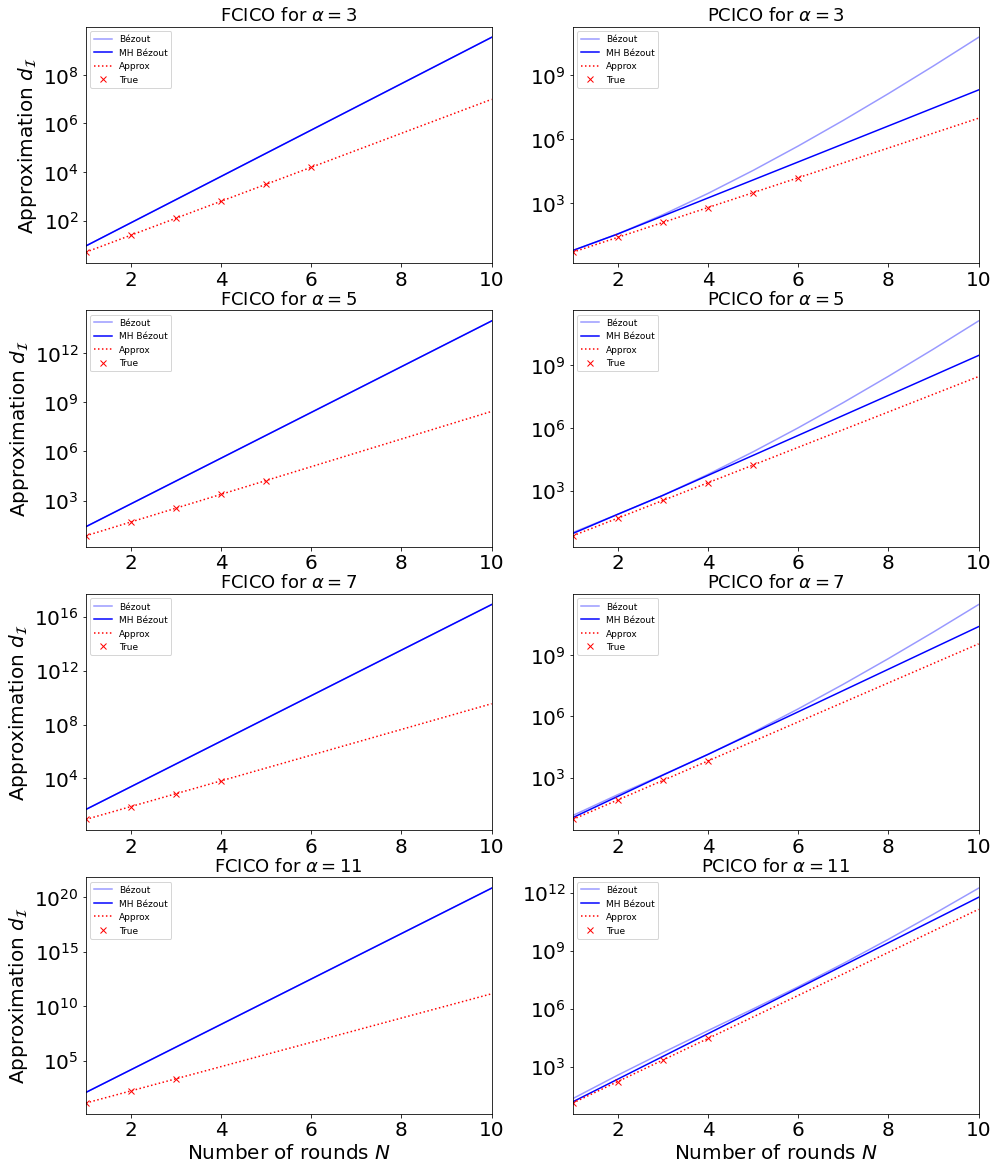

In [49]:
plot_vsdim(results_Fp, alphas=[3,5,7,11], rmax=10, saveTables=False)

# Derivation Round Numbers $(\mathbb{F}_p)$

In [50]:
def add_marker_points(ax, x, y, c, ymarg=1):
    ax.plot(x, y, marker='o', color=c) 
    ax.text(x, y+2, f'{y}', ha='center')
    
def save_table_data_to_file(x,y,title,filename,spec):
    f = open(f"tables/{filename}", spec)
    f.write("-"*100 + "\n")
    f.write(title + "\n")
    f.write("-"*100 + "\n")
    for xi,yi in zip(x,y):
        f.write(f"{xi:.2f} {yi}\n")
    f.write('\n')
    f.close()

def plot_conj_nr(alpha=3, wmin=1, wmax=3, wmark=[2], s=128, stepwidth=0.01, linewidth=1, ymin=0, ymax=50, saveTables=False):
    filename=f"conj_nr_a{alpha}_s{s}.txt"
    
    if saveTables:
        save_table_data_to_file([],[],f"Conjectured number of rounds (s={s})",filename,"w")
    
    nrows = 2 # One for each model
    ncols = 3 # one per step in GB computation
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(8 * ncols, 5 * nrows), sharey=False, sharex=False) 
    #fig.suptitle(f"Number of rounds")
    axs = [axs] if nrows == 1 else axs
    
    # Todo mark whole region when using bounds?
    # TODO maybe one image per step? Saying: For only this step, you need to choose like this / that.
    
    omegas = np.arange(wmin, wmax + stepwidth, stepwidth)  # Omegas
    widx = [ceil((w-wmin)/stepwidth) for w in wmark]
    
    colors = ['r','orange']
    
    for r_axs, m in zip(axs, ['FCICO','PCICO']): # One columns per model
        
        if saveTables:
            save_table_data_to_file([],[],m,filename,"a")
        
        for ax, step in zip(r_axs, ['GB','FGLM','FAC']):
            ax.set_title(f"{m}: {step} for $\\alpha = {alpha}$")
            ax.grid(True)
            
            ymin_ = 100
            ymax_ = 0
            
            if step == 'GB':
                # GB complexity approx from extrapolated dreg
                for i, f in enumerate(fun_dreg_approx[m]):
                    y = [find_opt_num_rounds_gb(fun_ne=eval(f"fun_ne_{m}"), fun_nv=eval(f"fun_nv_{m}"), fun_dreg=f, 
                                                fun_degs=eval(f"fun_degs_{m}"), alpha=alpha, w=w, s=s) for w in omegas]
                    ax.add_line(Line2D(omegas, y, color=colors[i], label=title_dreg_approx[m][i], linestyle='solid'))
                    ymin_, ymax_ = min(ymin_,min(y)), max(ymax_,max(y))
                    
                    # Plot point and value for w=2
                    for w, idx in zip(wmark,widx):
                        add_marker_points(ax=ax, x=w, y=y[idx], c=colors[i], ymarg=3*(-1)^i)
                    
                    if saveTables:
                        save_table_data_to_file(omegas,y,f"N* from GB approximation: {title_dreg_approx[m][i]}",filename,"a")
                
                # GB Macaulay upper
                y = [find_opt_num_rounds_gb(fun_ne=eval(f"fun_ne_{m}"), fun_nv=eval(f"fun_nv_{m}"), fun_dreg=eval(f"fun_mac_{m}"), 
                                            fun_degs=eval(f"fun_degs_{m}"), alpha=alpha, w=w, s=s) for w in omegas]
                ax.add_line(Line2D(omegas, y, color='b', label=f"Macaulay", linestyle='solid'))
                ymin_, ymax_ = min(ymin_,min(y)), max(ymax_,max(y))
                ax.fill_between(omegas, y, [ymax for _ in omegas], alpha=0.1, color='b')
                
                # Plot point and value for w=2
                for w, idx in zip(wmark,widx):
                    add_marker_points(ax=ax, x=w, y=y[idx], c='b', ymarg=-3)
                    
                if saveTables:
                    save_table_data_to_file(omegas,y,f"N* from GB Macaulay",filename,"a")
                    
            if step == 'FGLM':
                # FGLM complexity from experimental quotient space dimension
                y = [find_opt_num_rounds_fglm(fun_nv=eval(f"fun_nv_{m}"), fun_dI=eval(f"fun_dI_{m}"), 
                                            alpha=alpha, w=w, s=s) for w in omegas] 
                ax.add_line(Line2D(omegas, y, color=colors[0], label=f"Approx", linestyle='solid'))
                ymin_, ymax_ = min(ymin_,min(y)), max(ymax_,max(y))
                
                # Plot point and value for w=2
                for w, idx in zip(wmark,widx):
                    add_marker_points(ax=ax, x=w, y=y[idx], c=colors[0], ymarg=3)
                
                if saveTables:
                    save_table_data_to_file(omegas,y,f"N* from FGLM approximation",filename,"a")
                
                # FGLM complexity from Multihomogeneous Bézout bound
                y_mhb = [find_opt_num_rounds_fglm(fun_nv=eval(f"fun_nv_{m}"), fun_dI=eval(f"fun_mhb_{m}"), 
                                            alpha=alpha, w=w, s=s) for w in omegas] 
                ax.add_line(Line2D(omegas, y_mhb, color='b', label=f"MHB", linestyle='solid'))
                ymin_, ymax_ = min(ymin_,min(y_mhb)), max(ymax_,max(y_mhb))
                ax.fill_between(omegas, y_mhb, [ymax for _ in omegas], alpha=0.1, color='b')
                
                # Plot point and value for w=2
                for w, idx in zip(wmark,widx):
                    add_marker_points(ax=ax, x=w, y=y_mhb[idx], c='b', ymarg=-3)
                
                if saveTables:
                    save_table_data_to_file(omegas,y_mhb,f"N* from FGLM Multihomogeneous Bézout",filename,"a")
                
                # FGLM complexity from classical Bézout bound
                y_b = [find_opt_num_rounds_fglm(fun_nv=eval(f"fun_nv_{m}"), fun_dI=eval(f"fun_b_{m}"), 
                                            alpha=alpha, w=w, s=s) for w in omegas] 
                ax.add_line(Line2D(omegas, y_b, color='gray', label=f"B", linestyle='dashed'))
                ymin_, ymax_ = min(ymin_,min(y_b)), max(ymax_,max(y_b))
                ax.fill_between(omegas, y_b, y_mhb, alpha=0.1, color='gray')
                
                # Plot point and value for w=2
                for w, idx in zip(wmark,widx):
                    add_marker_points(ax=ax, x=w, y=y_b[idx], c='gray', ymarg=-3)
                
                if saveTables:
                    save_table_data_to_file(omegas,y_b,f"N* from FGLM Classical Bézout",filename,"a")
            
            if step == 'FAC':
                # FAC complexity from experimental quotient space dimension (= degree of univ poly for shape position)
                #y = [find_opt_num_rounds_fac(fun_udeg=eval(f"fun_dI_{m}"), alpha=alpha, s=s) for w in omegas] 
                # FAC is independent of omega
                y = find_opt_num_rounds_fac(fun_udeg=eval(f"fun_udeg_{m}"), alpha=alpha, s=s)
                ax.add_line(Line2D([omegas[0],omegas[-1]], [y,y], color=colors[0], label=f"Approx", linestyle='solid'))
                ymin_, ymax_ = min(ymin_,y), max(ymax_,y)
                
                # Plot point and value for w=2
                for w, idx in zip(wmark,widx):
                    add_marker_points(ax=ax, x=w, y=y, c=colors[0], ymarg=3)
                
                if saveTables:
                    save_table_data_to_file([omegas[0],omegas[-1]],[y,y],f"N* from FAC approximation",filename,"a")
                
                # FAC complexity from Multihomogeneous Bézout bound
                y_mhb = find_opt_num_rounds_fac(fun_udeg=eval(f"fun_mhb_{m}"), alpha=alpha, s=s)
                ax.add_line(Line2D([omegas[0],omegas[-1]], [y_mhb,y_mhb], color='b', label=f"MHB", linestyle='solid'))
                ymin_, ymax_ = min(ymin_,y_mhb), max(ymax_,y_mhb)
                ax.fill_between(omegas, y_mhb, ymax, alpha=0.1, color='b')
                
                # Plot point and value for w=2
                for w, idx in zip(wmark,widx):
                    add_marker_points(ax=ax, x=w, y=y_mhb, c='b', ymarg=-3)
                
                if saveTables:
                    save_table_data_to_file([omegas[0],omegas[-1]],[y_mhb,y_mhb],f"N* from FAC Multihomogeneous Bézout",filename,"a")
                
                # FAC complexity from classical Bézout bound
                y_b = find_opt_num_rounds_fac(fun_udeg=eval(f"fun_b_{m}"), alpha=alpha, s=s)
                ax.add_line(Line2D([omegas[0],omegas[-1]], [y_b,y_b], color='gray', label=f"B", linestyle='dashed'))
                ymin_, ymax_ = min(ymin_,y_b), max(ymax_,y_b)
                ax.fill_between(omegas, y_b, y_mhb, alpha=0.1, color='gray')
                
                if saveTables:
                    save_table_data_to_file([omegas[0],omegas[-1]],[y_b,y_b],f"N* from FAC Classical Bézout",filename,"a")
                
                # Plot point and value for w=2
                for w, idx in zip(wmark,widx):
                    add_marker_points(ax=ax, x=w, y=y_b, c='gray', ymarg=-3)
            
            ax.set_xlim(wmin, wmax)
            #ax.set_ylim(ymin, ymax_)
            ax.set_ylim(ymin, ymax)
            ax.legend(loc=1, fontsize="9")
    
    # Labels
    xlabel="w"
    ylabel=f"N* for s={s}"
    
    if nrows > 1:
        if ncols > 1:
            plt.setp(axs[-1, :], xlabel=xlabel)
            plt.setp(axs[:, 0], ylabel=ylabel)
        else:
            plt.setp(axs[-1], xlabel=xlabel)
            plt.setp(axs[:], ylabel=ylabel)
    else:
        if ncols > 1:
            plt.setp(axs[:], xlabel=xlabel)
            plt.setp(axs[0], ylabel=ylabel)
        else:
            plt.setp(axs, xlabel=xlabel)
            plt.setp(axs, ylabel=ylabel)
            
    plt.show()

### $s =  128$

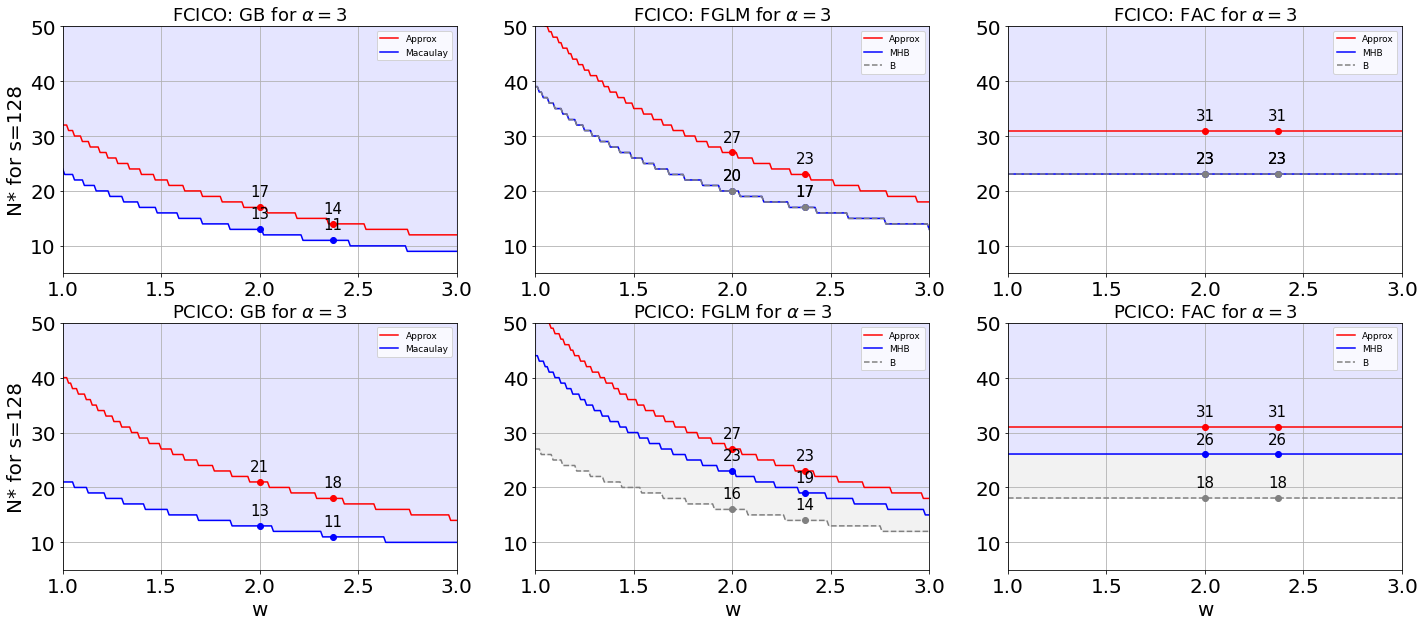

In [51]:
plot_conj_nr(s=128, alpha=3, saveTables=False, ymin=5, ymax=50, stepwidth=0.01, wmark=[2,2.37])

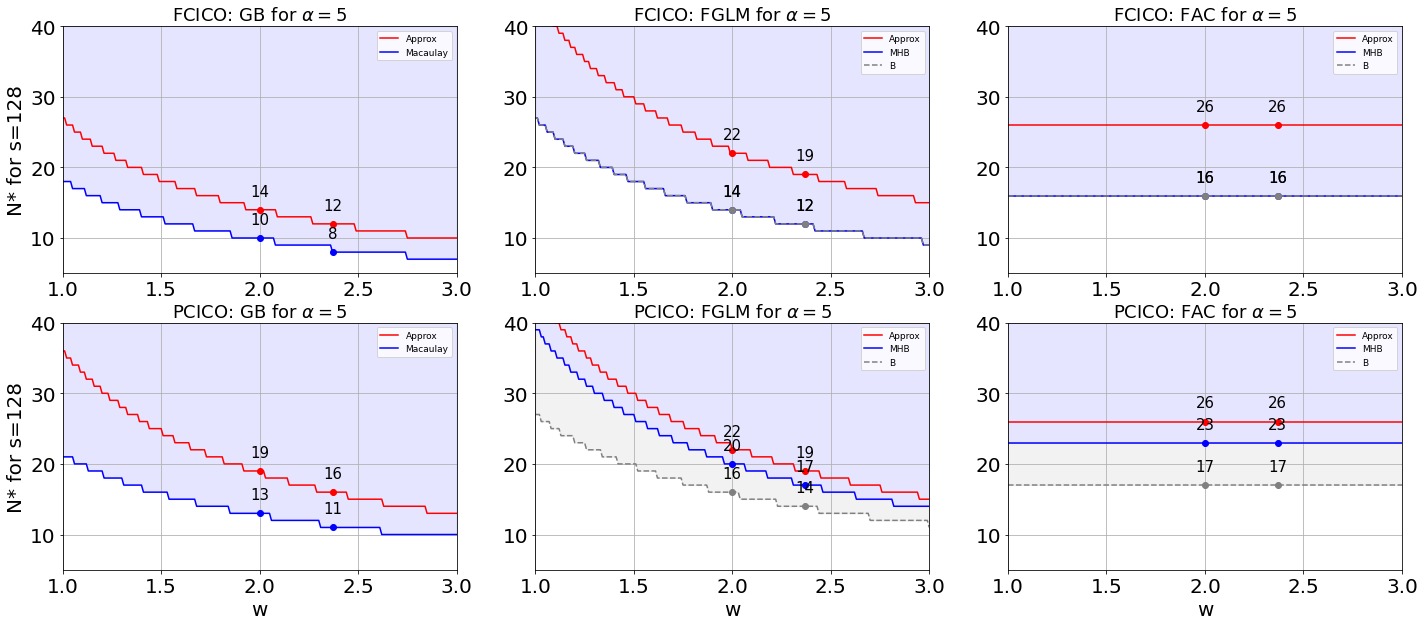

In [52]:
plot_conj_nr(s=128, alpha=5, saveTables=False, ymin=5, ymax=40, stepwidth=0.01, wmark=[2,2.37])

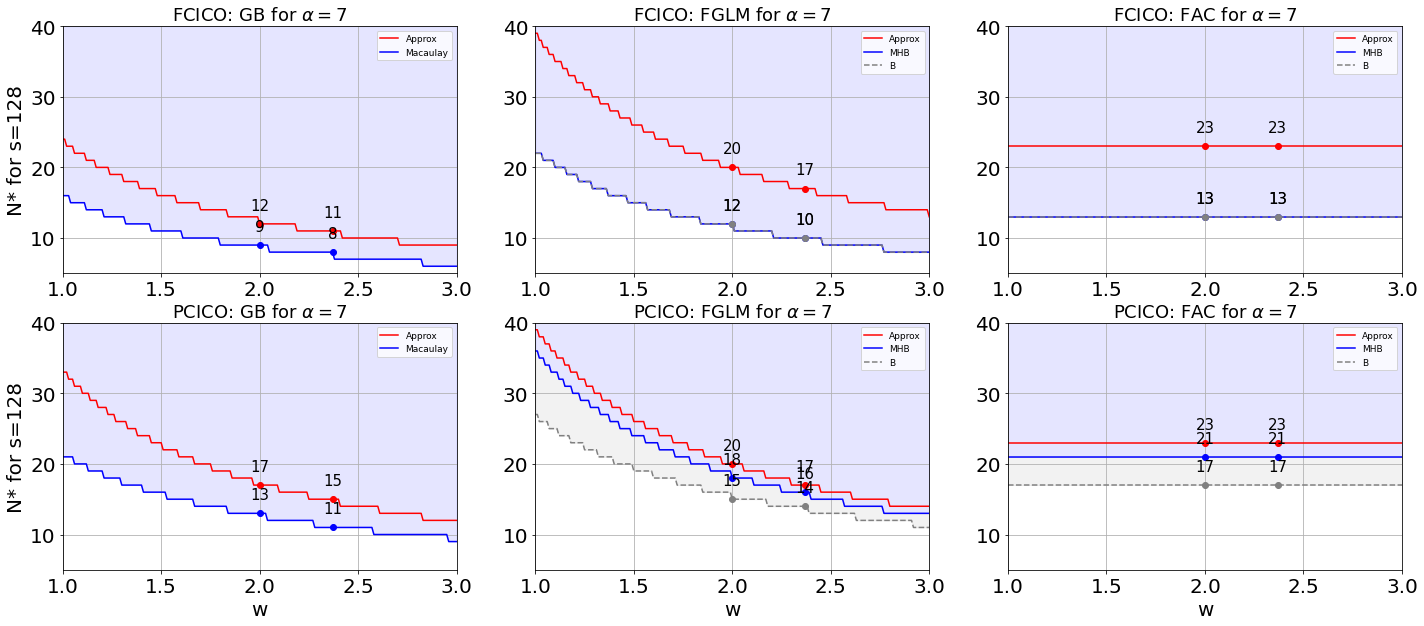

In [53]:
plot_conj_nr(s=128, alpha=7, saveTables=False, ymin=5, ymax=40, stepwidth=0.01, wmark=[2,2.37])

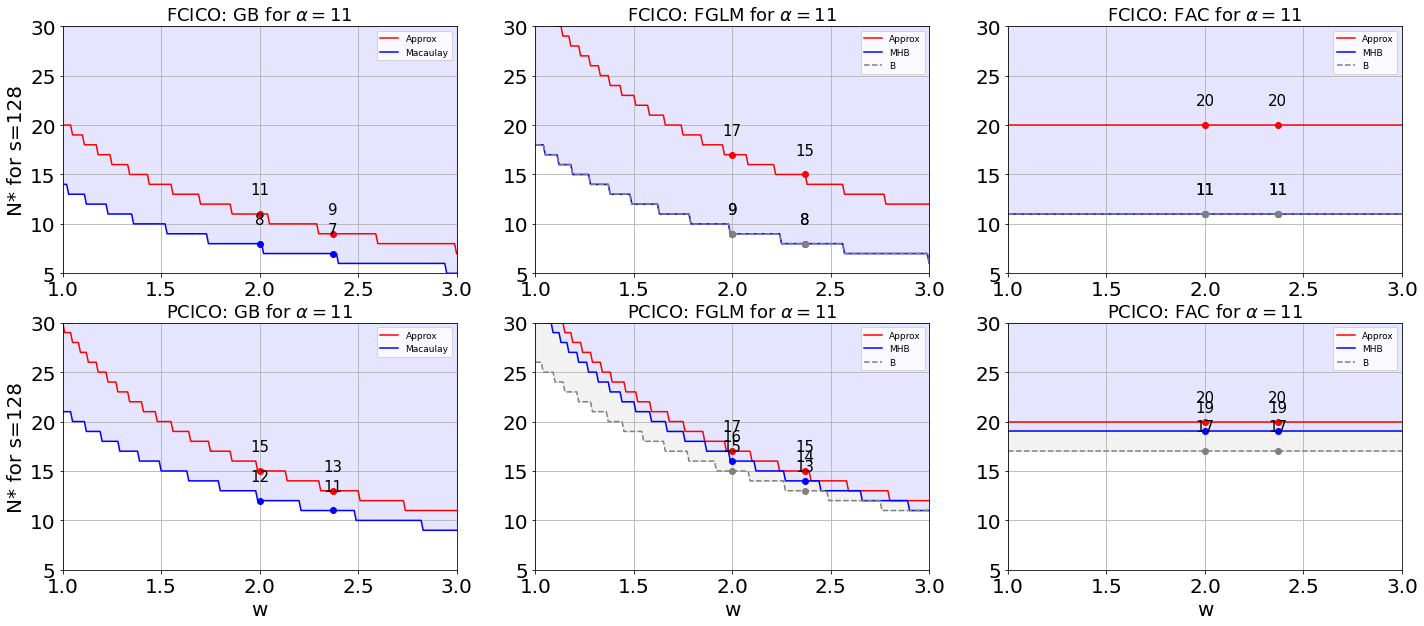

In [54]:
plot_conj_nr(s=128, alpha=11, saveTables=False, ymin=5, ymax=30, stepwidth=0.01, wmark=[2,2.37])

### $s =  256$

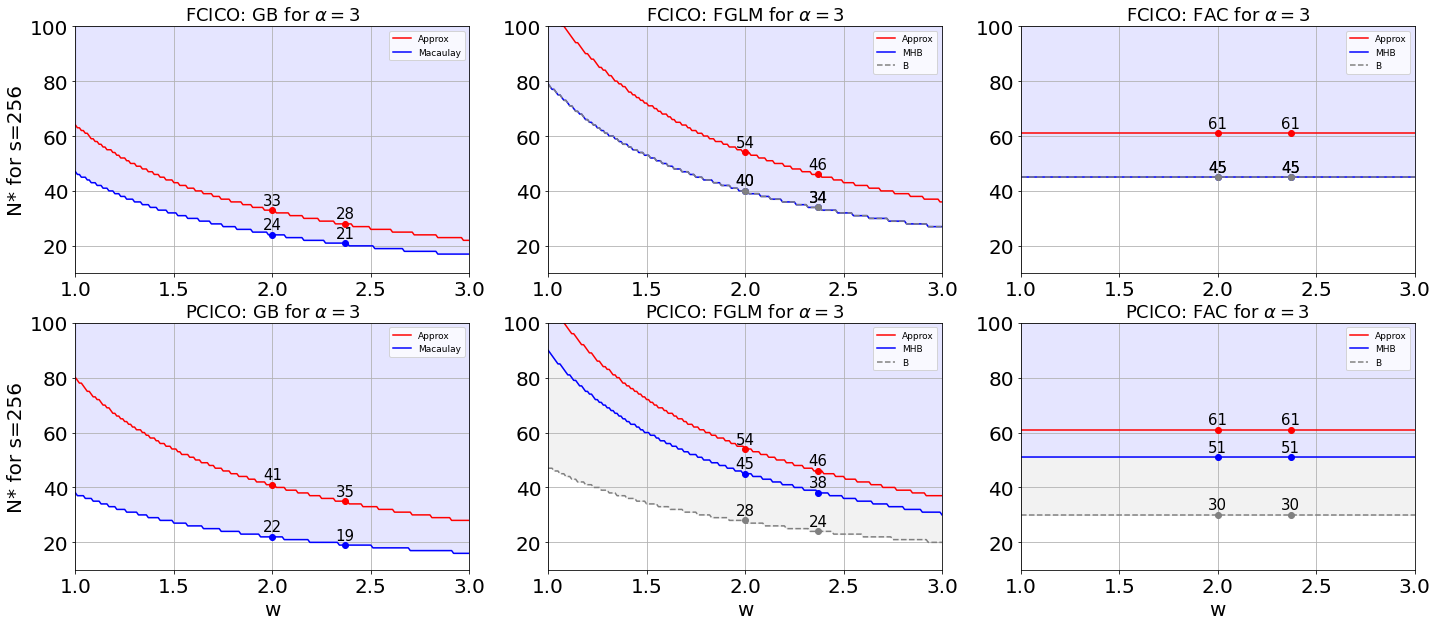

In [55]:
plot_conj_nr(s=256, alpha=3, saveTables=False, ymin=10, ymax=100, stepwidth=0.01, wmark=[2,2.37])

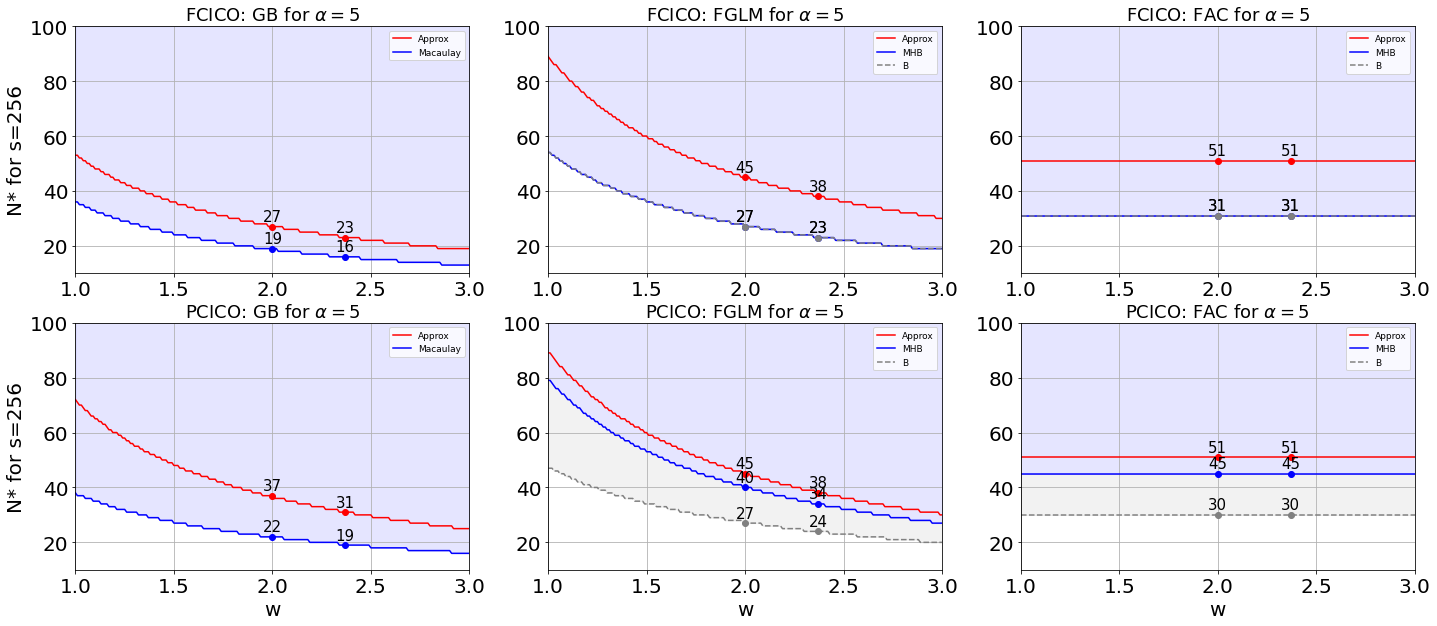

In [56]:
plot_conj_nr(s=256, alpha=5, saveTables=False, ymin=10, ymax=100, stepwidth=0.01, wmark=[2,2.37])

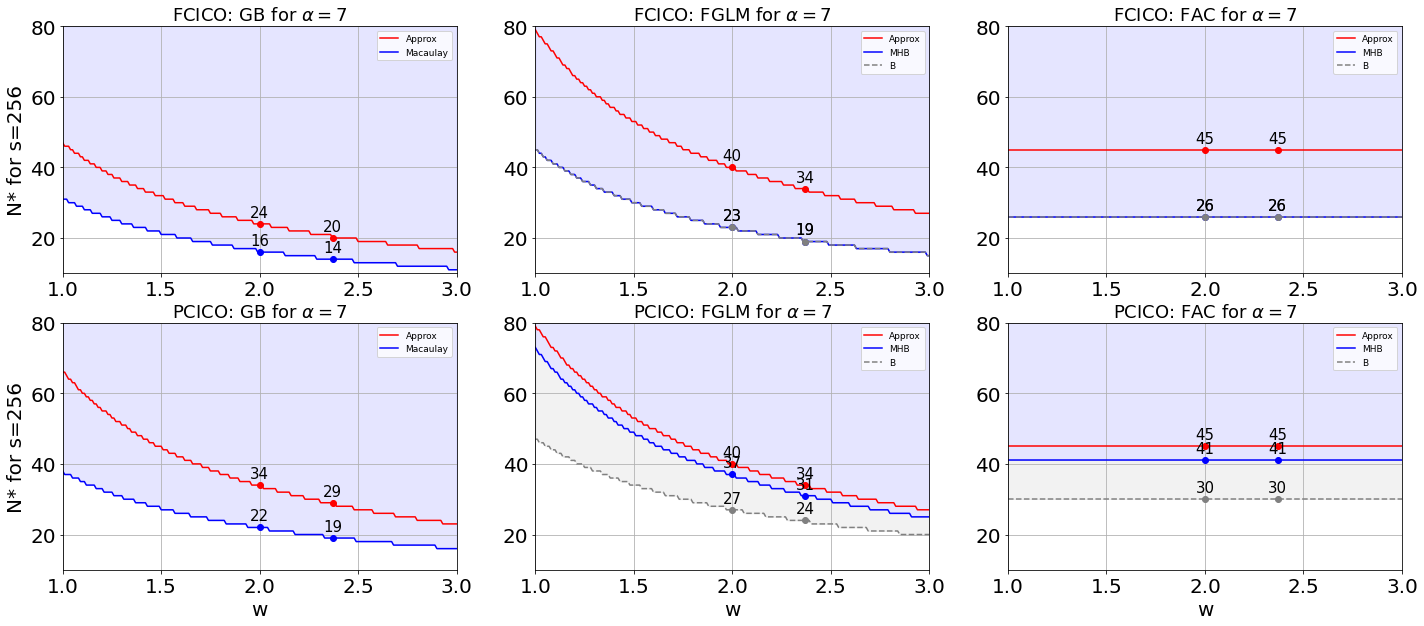

In [57]:
plot_conj_nr(s=256, alpha=7, saveTables=False, ymin=10, ymax=80, stepwidth=0.01, wmark=[2,2.37])

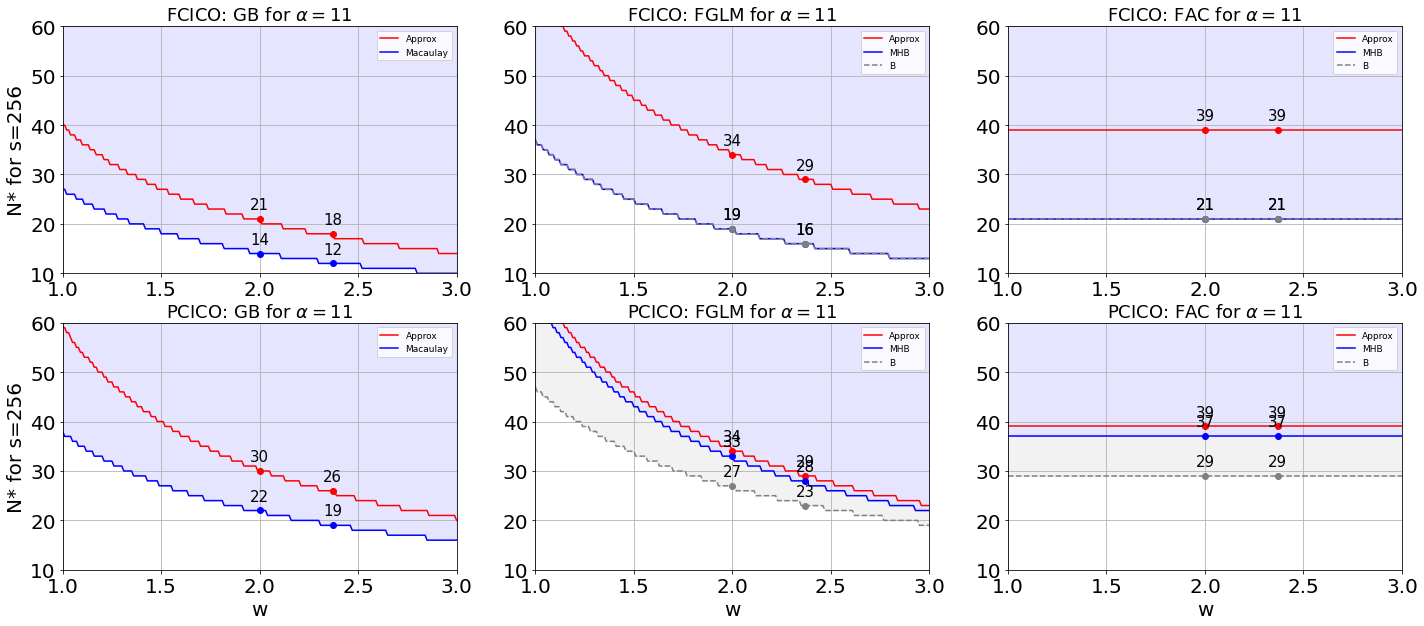

In [58]:
plot_conj_nr(s=256, alpha=11, saveTables=False, ymin=10, ymax=60, stepwidth=0.01, wmark=[2,2.37])

# Complexity for specific number of rounds

In [59]:
# Get complexity for fixed round number
def get_complexity_N(N, alpha, N_anemoi, models=['FCICO','PCICO']):
    tableData = [['Model','AP','E1','E2','E3','T1','T2','T3']]
    for m in models:
        ne, nv = eval(f"fun_ne_{m}({N})"), eval(f"fun_nv_{m}({N})")
        degs = eval(f"fun_degs_{m}({N},{alpha})")
        
        dI_e, dI_t = eval(f"fun_dI_{m}({N},{alpha})"), eval(f"fun_mhb_{m}({N},{alpha})")
        dreg_e, dreg_t = fun_dreg_approx[m][0](N,alpha), eval(f"fun_mac_{m}({N},{alpha})")
        
        #print(ne,nv,degs,dI_e,dI_t,dreg_e,dreg_t)
        
        # GB step
        c_gb_e_2, c_gb_e_237, c_gb_e_281 = gb_complexity(ne, nv, dreg_e, w=2, degs=degs), gb_complexity(ne, nv, dreg_e, w=2.37, degs=degs), gb_complexity(ne, nv, dreg_e, w=2.81, degs=degs)
        c_gb_t_2, c_gb_t_237, c_gb_t_281 = gb_complexity(ne, nv, dreg_t, w=2, degs=degs), gb_complexity(ne, nv, dreg_t, w=2.37, degs=degs), gb_complexity(ne, nv, dreg_t, w=2.81, degs=degs)
        
        # FGLM step
        c_fglm_e_2, c_fglm_e_237, c_fglm_e_281 = fglm_complexity(nv, dI_e, w=2), fglm_complexity(nv, dI_e, w=2.37), fglm_complexity(nv, dI_e, w=2.81)
        c_fglm_t_2, c_fglm_t_237, c_fglm_t_281 = fglm_complexity(nv, dI_t, w=2), fglm_complexity(nv, dI_t, w=2.37), fglm_complexity(nv, dI_t, w=2.81)
        
        # FAC step
        c_fac_e = fac_complexity(dI_e)
        c_fac_t = fac_complexity(dI_t)
        
        tableData.append([m, f"{N_anemoi}", f"{c_gb_e_2} ({c_gb_e_237}, {c_gb_e_281})", f"{c_fglm_e_2} ({c_fglm_e_237}, {c_fglm_e_281})", f"{c_fac_e}", 
                          f"{c_gb_t_2} ({c_gb_t_237}, {c_gb_t_281})", f"{c_fglm_t_2} ({c_fglm_t_237}, {c_fglm_t_281})", f"{c_fac_t}"])
        
    return table(tableData, header_row=True, header_column=True)

### $\alpha = 3$

In [60]:
get_complexity_N(N=21, alpha=3, N_anemoi=128)

Model | AP    E1               E2               E3   T1               T2               T3
+-------+-----+----------------+----------------+----+----------------+----------------+-----+
  FCICO | 128   165 (195, 231)   102 (120, 142)   88   226 (267, 316)   138 (163, 192)   120
  PCICO | 128   131 (155, 184)   101 (120, 141)   88   249 (293, 347)   121 (143, 168)   106

In [61]:
get_complexity_N(N=37, alpha=3, N_anemoi=256)

Model | AP    E1               E2               E3    T1               T2               T3
+-------+-----+----------------+----------------+-----+----------------+----------------+-----+
  FCICO | 256   293 (347, 411)   178 (209, 247)   155   402 (476, 563)   240 (284, 335)   212
  PCICO | 256   234 (277, 329)   177 (208, 246)   155   497 (587, 694)   212 (250, 295)   187

### $\alpha = 5$: Instantiations for BLS12-381 and BN-254 Sponge

In [62]:
get_complexity_N(N=21, alpha=5, N_anemoi=128)

Model | AP    E1               E2               E3    T1               T2               T3
+-------+-----+----------------+----------------+-----+----------------+----------------+-----+
  FCICO | 128   200 (237, 280)   123 (145, 171)   107   296 (350, 414)   200 (236, 279)   177
  PCICO | 128   147 (174, 206)   122 (144, 170)   107   249 (294, 347)   137 (161, 190)   120

In [63]:
get_complexity_N(N=37, alpha=5, N_anemoi=256)

Model | AP    E1               E2               E3    T1               T2               T3
+-------+-----+----------------+----------------+-----+----------------+----------------+-----+
  FCICO | 256   356 (421, 498)   213 (252, 298)   188   527 (624, 738)   349 (413, 489)   311
  PCICO | 256   262 (310, 368)   212 (251, 297)   188   497 (587, 694)   239 (282, 334)   212

### $\alpha = 7$

In [64]:
get_complexity_N(N=20, alpha=7, N_anemoi=128)

Model | AP    E1               E2               E3    T1               T2               T3
+-------+-----+----------------+----------------+-----+----------------+----------------+-----+
  FCICO | 128   216 (256, 303)   132 (155, 183)   115   324 (382, 452)   229 (271, 320)   203
  PCICO | 128   153 (180, 213)   131 (154, 182)   115   235 (277, 328)   142 (168, 198)   125

In [65]:
get_complexity_N(N=36, alpha=7, N_anemoi=256)

Model | AP    E1               E2               E3    T1               T2               T3
+-------+-----+----------------+----------------+-----+----------------+----------------+-----+
  FCICO | 256   392 (464, 550)   234 (276, 326)   207   589 (696, 824)   410 (485, 574)   366
  PCICO | 256   277 (327, 388)   233 (275, 325)   207   481 (568, 672)   254 (300, 354)   225

### $\alpha = 11$

In [66]:
get_complexity_N(N=19, alpha=11, N_anemoi=128)

Model | AP    E1               E2               E3    T1               T2               T3
+-------+-----+----------------+----------------+-----+----------------+----------------+-----+
  FCICO | 128   241 (286, 338)   145 (171, 202)   127   359 (424, 501)   268 (316, 374)   238
  PCICO | 128   163 (192, 228)   144 (170, 201)   127   223 (263, 311)   152 (180, 212)   134

In [67]:
get_complexity_N(N=35, alpha=11, N_anemoi=256)

Model | AP    E1               E2               E3    T1               T2               T3
+-------+-----+----------------+----------------+-----+----------------+----------------+-----+
  FCICO | 256   449 (532, 630)   265 (313, 370)   235   668 (790, 936)   490 (580, 686)   439
  PCICO | 256   301 (356, 422)   264 (312, 369)   235   466 (551, 651)   278 (329, 389)   248

In [68]:
def print_table_freelunch(w=2, models=['FCICO','PCICO']):
    anemoi_rounds = {128: {3:21, 5:21, 7:20, 11:19}, 256: {3:37, 5:37, 7:36, 11:35}}
    
    # Get complexity for fixed round number
    tableData = [[f"Security Claim","$\\alpha=3$","$\\alpha=5$","$\\alpha=7$","$\\alpha=11$"]]
    
    for s in anemoi_rounds:
        tableData.append([s])
        
        for alpha in sorted(anemoi_rounds[s]):
            
            N = anemoi_rounds[s][alpha]
            m = 'PCICO'
            ne, nv = eval(f"fun_ne_{m}({N})"), eval(f"fun_nv_{m}({N})")
            degs = eval(f"fun_degs_{m}({N},{alpha})")

            dI_e, dI_t = eval(f"fun_dI_{m}({N},{alpha})"), eval(f"fun_mhb_{m}({N},{alpha})")
            dreg_e, dreg_t = fun_dreg_approx[m][0](N,alpha), eval(f"fun_mac_{m}({N},{alpha})")

            # FGLM step
            c_fglm_e = fglm_complexity(nv, dI_e, w=w)

            tableData[-1].append(f"{c_fglm_e} ({N})")


    return table(tableData, header_row=True, header_column=True)

In [69]:
print_table_freelunch(w=2)

Security Claim | $\alpha=3$   $\alpha=5$   $\alpha=7$   $\alpha=11$
+----------------+------------+------------+------------+-------------+
  128            | 101 (21)     122 (21)     131 (20)     144 (19)
  256            | 177 (37)     212 (37)     233 (36)     264 (35)

In [70]:
print_table_freelunch(w=2.37)

Security Claim | $\alpha=3$   $\alpha=5$   $\alpha=7$   $\alpha=11$
+----------------+------------+------------+------------+-------------+
  128            | 120 (21)     144 (21)     154 (20)     170 (19)
  256            | 208 (37)     251 (37)     275 (36)     312 (35)

In [71]:
print_table_freelunch(w=2.81)

Security Claim | $\alpha=3$   $\alpha=5$   $\alpha=7$   $\alpha=11$
+----------------+------------+------------+------------+-------------+
  128            | 141 (21)     170 (21)     182 (20)     201 (19)
  256            | 246 (37)     297 (37)     325 (36)     369 (35)

In [72]:
print_table_freelunch(w=3)

Security Claim | $\alpha=3$   $\alpha=5$   $\alpha=7$   $\alpha=11$
+----------------+------------+------------+------------+-------------+
  128            | 150 (21)     181 (21)     194 (20)     215 (19)
  256            | 262 (37)     316 (37)     347 (36)     393 (35)